In [1]:
from IPython.core.display import display, HTML

In [2]:
HTML('''<script>code_show=true;function code_toggle()
{if (code_show){$('div.input').hide();} 
else{$('div.input').show();}code_show = !code_show}$( document ).ready(code_toggle);
</script><em>The raw code in this jupyter notebook is hidden by default for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</,!a></em>.''')

In [3]:
# install this to use some extra jupyter features (like content, this really helps navigate)
#! jupyter contrib nbextension install --system
#! pip install jupyter_contrib_nbextensions

In [4]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:5px;
margin-bottom:10px;
}

div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:20px;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

<font size="5">Import various general modules</font>

In [7]:
import sys
import myPlots
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 7)
from scipy import constants
from scipy.integrate import simps
import warnings
warnings.filterwarnings("ignore")
import itertools as it

<font size="5">Assign a saving folder (where all the data and plots will be saved)</font>

In [8]:
saveFolder='./results/skySimulation/'

<font size="5">Set Offline path</font>

In [9]:
offlinePath='/home/max/auger/soft/offline/install/'

Interactive or inline plotting (by default the plots are inline).

In [10]:
# for interactive plots (zoom, etc) use:
# %matplotlib notebook #uncomment this
# to turn it off use:
# %matplotlib inline #uncomment this

In [11]:
# If it does not work try some of these:
# import mpld3
# mpld3.enable_notebook()
# mpld3.disable_notebook()
# %matplotlib tk  
# %matplotlib qt #etc. - GUI windows show the figure externally to the notebook with the given interactive backend

# Antenna pattern
<p style='text-align: justify;'>
The class <i>getAntennaPatternQuantities</i> reads the Offline XML file with the Antenna pattern. Further, it allows you to transform the antenna pattern's Offline azimuth convention 0$^\circ$,360$^\circ$ (with 0$^\circ$ at East and North at +90$^\circ$) to azimuth convention -180$^\circ$,180$^\circ$ (With East at +90$^\circ$ and West at -90$^\circ$) and from zenith to altitude. This convention is what is internal used by healpy. Also, you can interpolate the antenna pattern. See the examples. <br>
***
!!! Note that the NS antenna pattern in Offline is align to NS sensitivity. During the run Offline properly rotates the antenna pattern.
See RModels_RD.xml and check the part with $<$OrientationAzimuth$>$.
That is why the convention transformation in the class <i>getAntennaPatternQuantities</i> is different for the EW and NS orientation.
 </p>

In [12]:
# modules need by this class
from collections import OrderedDict
import os
from lxml import etree as ET
from io import StringIO
from scipy.interpolate import interp1d

class getAntennaPatternQuantities():
    def __init__(self,antennaPath):
        self._frequencyXML, phiXML, thetaXML, MeanTransferXML, self._theta_ampXML, self._theta_phaseXML,\
        self._phi_ampXML, self._phi_phaseXML = self._read_rp(antennaPath)
        self._phi = list(OrderedDict.fromkeys(phiXML))
        self._theta = list(OrderedDict.fromkeys(thetaXML))
        self._templateDF = self._DFtemplateCreator(self._theta,self._phi,yName='phi')
    def _DFtemplateCreator(self,xs,ys,yName=None):
        colList = [str(x) for x in xs]
        nan_init = np.empty((len(xs),len(ys),))
        nan_init[:]=np.nan
        templateDF = pd.DataFrame(nan_init.T, columns = colList)
        templateDF.insert(0,yName,ys)
        templateDF = templateDF.set_index(yName)
        return templateDF
    def _interpolate(self,df,newAxisValues, axis,kind='linear',
        copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False):
        if axis == 0:
            InterpFunc = interp1d(df.index.values.astype(float),df.values,kind=kind,axis=0,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
            templateDF = self._DFtemplateCreator(df.columns.values.astype(float),newAxisValues, yName='phi')
        elif axis == -1:
            InterpFunc = interp1d(df.columns.values.astype(float),df.values,kind=kind,axis=-1,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
            templateDF = self._DFtemplateCreator(newAxisValues,df.index.values.astype(float), yName='phi')
        newValues = InterpFunc(newAxisValues)
        templateDF.iloc[:,:] = newValues
        return templateDF
    def get(self, frequency=45, quantity='', newPhi=None, newTheta=None,changeConvention=False,orientation=False,
        kind='linear',copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False):
        #print('Getting quantity: '+quantity+' at frequency: '+str(frequency))
        findex = np.where(self._frequencyXML==frequency)[0][0]
        temporaryDF = self._templateDF.copy(deep=True)
        if quantity != 'absHeight':
            exec('temporaryDF.iloc[:,:] = self._'+quantity+'XML[findex].reshape(len(self._phi),len(self._theta))')
        elif quantity == 'absHeight':
            absHeight = np.sqrt( (1/2)* (self._theta_ampXML[findex].reshape(len(self._phi),len(self._theta))**2 + 
            self._phi_ampXML[findex].reshape(len(self._phi),len(self._theta))**2)   )
            temporaryDF.iloc[:,:] = absHeight
        if changeConvention == True:
            temporaryDF = self._changeAzimuthDefinitionAndZenith2Altitude(temporaryDF,orientation=orientation)
        # if interpolate
        if newPhi is not None:
            temporaryDF = self._interpolate(temporaryDF, newPhi, axis=0, kind=kind,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
        if newTheta is not None:
            temporaryDF = self._interpolate(temporaryDF, newTheta, axis=-1, kind=kind,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
        return temporaryDF
    def _changeAzimuthDefinitionAndZenith2Altitude(self, df,orientation=False):
        #def changeAzimuthDefinitionAndZenith2Altitude(temporaryDF):
        # drop last coll since it is just copy of the first row to make things periodical
        df = df.drop(index=360.0)
        # change the azimuth order from counterclockwise to clockwise by -1 and rotate it by 90 deg to align North to 0
        newIndex = np.asarray(df.index)
        if orientation == 'EW':
            newIndex=-(newIndex-90)
        elif orientation == 'NS':
            newIndex=-(newIndex-180)
        else:
            print('Set orientation of the antenna!')
        # fix values outside the -180 to 180 interval
        newIndex[np.where(newIndex<-180)] = newIndex[np.where(newIndex< -180)]+360
        # set new index and sort by it
        df=df.set_index(newIndex)
        df=df.sort_index()
        # find which periodical row is missing and add it
        try:
            lastRow = df.loc[-180.0]
            lastRow.name=180.0
        except:
            lastRow = df.loc[180.0]
            lastRow.name=-180.0
        df=df.append(lastRow)
        df=df.sort_index()
        # now change zenith to altitude
        cols=df.columns.tolist()
        df=df[cols[::-1]]
        df.columns=cols
        return df
    def getPhiAndThetaGrid(self):
        return np.meshgrid(self._phi, self._theta)
    def _read_rp(self, path): # credits to KIT for this funcion If the original author find this, send me your name :) !!!
        def get_component(root, comp):
            component = []
            for x in root.findall(comp):
                component.append(string_to_float_array(x.text))
            return np.array(component)
        def string_to_float_array(string, det=" "):# credits to KIT for this funcion
            return np.array([float(x) for x in string.split(det) if x.strip()])
        fopen = open(path, "r")
        fstring = fopen.read()
        # to create proper root
        fstring = "<rp>" + fstring + "</rp>"
        # get parser and tree
        parser = ET.XMLParser(remove_blank_text=True, remove_comments=True)
        tree = ET.parse(StringIO(fstring), parser)
        # get root object
        rp_root = tree.getroot()
        frequency = string_to_float_array(rp_root.find("frequency").text)
        phi = string_to_float_array(rp_root.find("phi").text)
        theta = string_to_float_array(rp_root.find("theta").text)
        MeanTransfer = string_to_float_array(rp_root.find("MeanTransfer").text)
        theta_amp = get_component(rp_root, "EAHTheta_amp")
        theta_phase = get_component(rp_root, "EAHTheta_phase")
        phi_amp = get_component(rp_root, "EAHPhi_amp")
        phi_phase = get_component(rp_root, "EAHPhi_phase")
        for x in [theta_phase, phi_amp, phi_phase]:
            if theta_amp.shape != x.shape:
                sys.exit("Mismatch component")
        if len(frequency) != len(MeanTransfer):
            sys.exit("Mismatch MeanTransfer")
        if len(frequency) != theta_amp.shape[0] or len(phi) != theta_amp.shape[1] or len(theta) != theta_amp.shape[1]:
            print(len(frequency), len(phi), len(theta), theta_amp.shape)
            sys.exit("Mismatch directions")
        return frequency, phi, theta, MeanTransfer, theta_amp, theta_phase, phi_amp, phi_phase

Set path to the antenna pattern XML files.

In [13]:
antennaPathEW = offlinePath+'/share/auger-offline/config/SALLA_RD_NEC2_with-WCD-SSD_EW.xml'
antennaPathNS = offlinePath+'/share/auger-offline/config/SALLA_RD_NEC2_with-WCD-SSD_NS.xml'

Create antenna class for EW and NS orientation.

In [14]:
antennaEW = getAntennaPatternQuantities(antennaPathEW)
antennaNS = getAntennaPatternQuantities(antennaPathNS)

## Examples

### Plot of antenna pattern quantity Q at frequency F

cmap.T:  256
tmins:  5.957178257653379e-13  tmax:  2.275922210609798  Tstep:  9
cbarTicks:  [5.95717826e-13 2.84490276e-01 5.68980553e-01 8.53470829e-01
 1.13796111e+00 1.42245138e+00 1.70694166e+00 1.99143193e+00
 2.27592221e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/EW_phi_amp_45Mhz


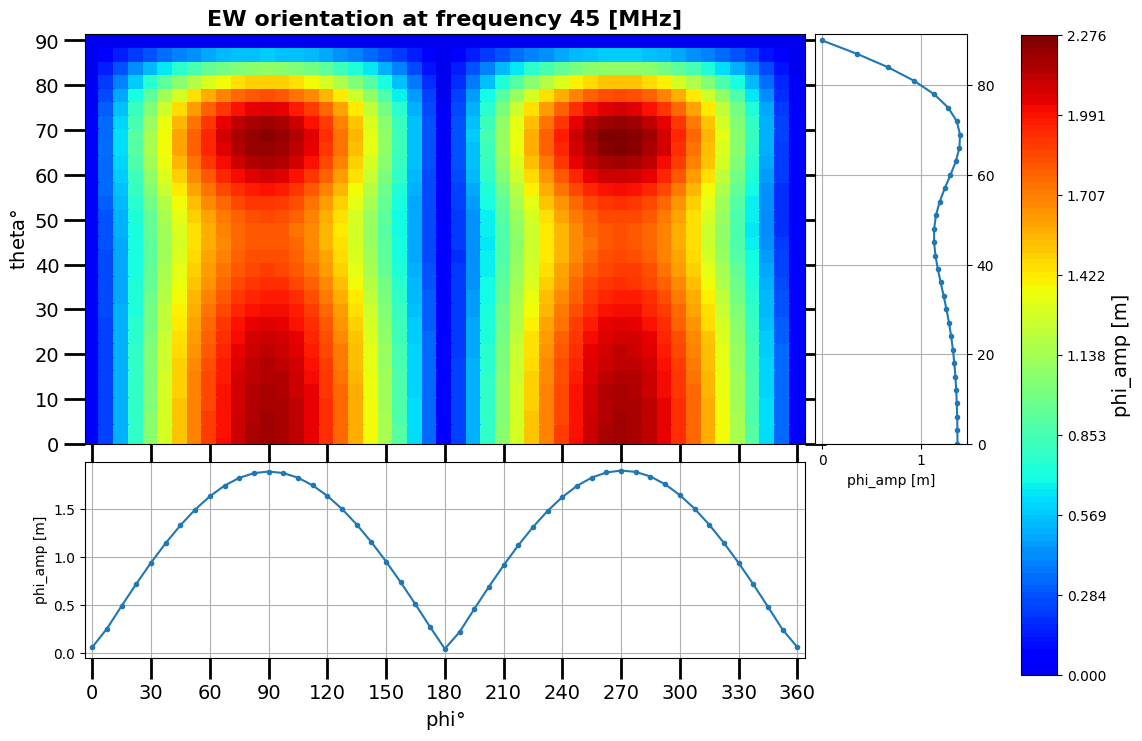

cmap.T:  256
tmins:  5.428794415618585e-13  tmax:  2.1381560698956927  Tstep:  9
cbarTicks:  [5.42879442e-13 2.67269509e-01 5.34539017e-01 8.01808526e-01
 1.06907803e+00 1.33634754e+00 1.60361705e+00 1.87088656e+00
 2.13815607e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/NS_phi_amp_45Mhz


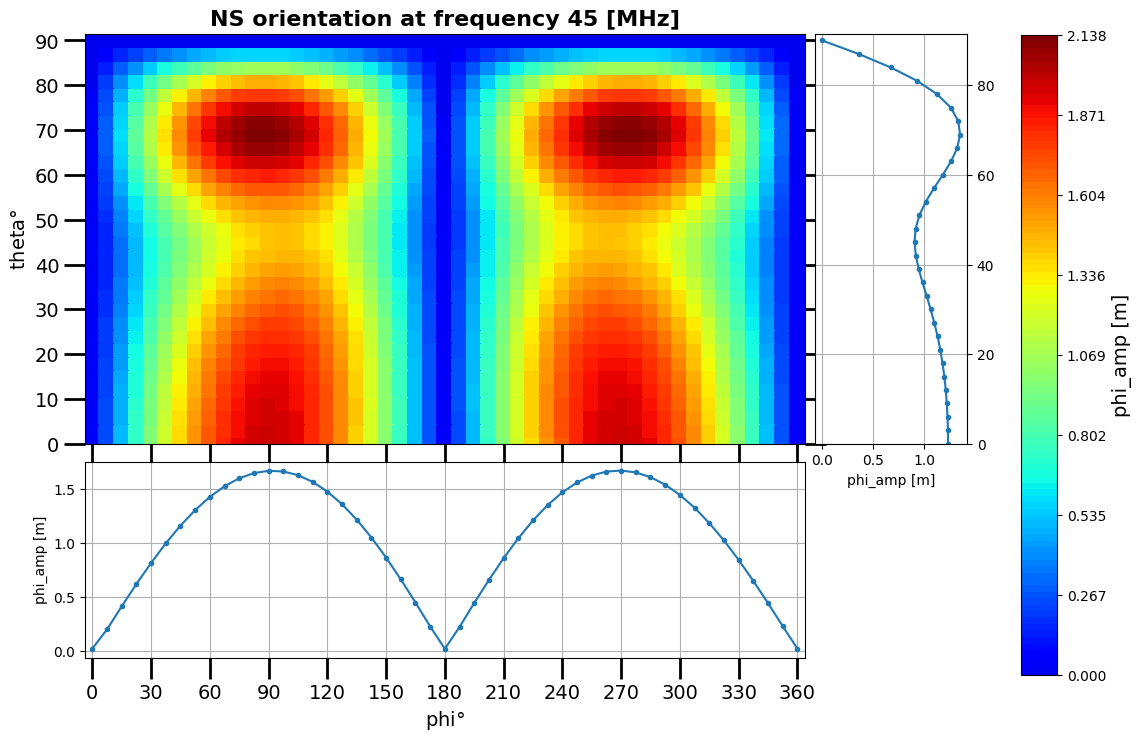

In [15]:
# select frequency
frequency=45

# choose quantity
quantity = 'phi_amp'
# quantity = 'theta_amp'
# quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW
Amp = antenna.get(quantity=quantity,frequency=frequency)

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30, yMajorLocator=10, figureWidth=12, figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)
    
# select NS orientation
orientation = 'NS'
antenna=antennaNS
Amp = antenna.get(quantity=quantity,frequency=frequency)
save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30, yMajorLocator=10, figureWidth=12, figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

### Plot of antenna pattern quantity Q at frequency F with interpolated phi and theta coordinates

cmap.T:  256
tmins:  5.957178257653379e-13  tmax:  2.2785828950003246  Tstep:  9
cbarTicks:  [5.95717826e-13 2.84822862e-01 5.69645724e-01 8.54468586e-01
 1.13929145e+00 1.42411431e+00 1.70893717e+00 1.99376003e+00
 2.27858290e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/EW_phi_amp_45Mhz_thetaInterp_cubic


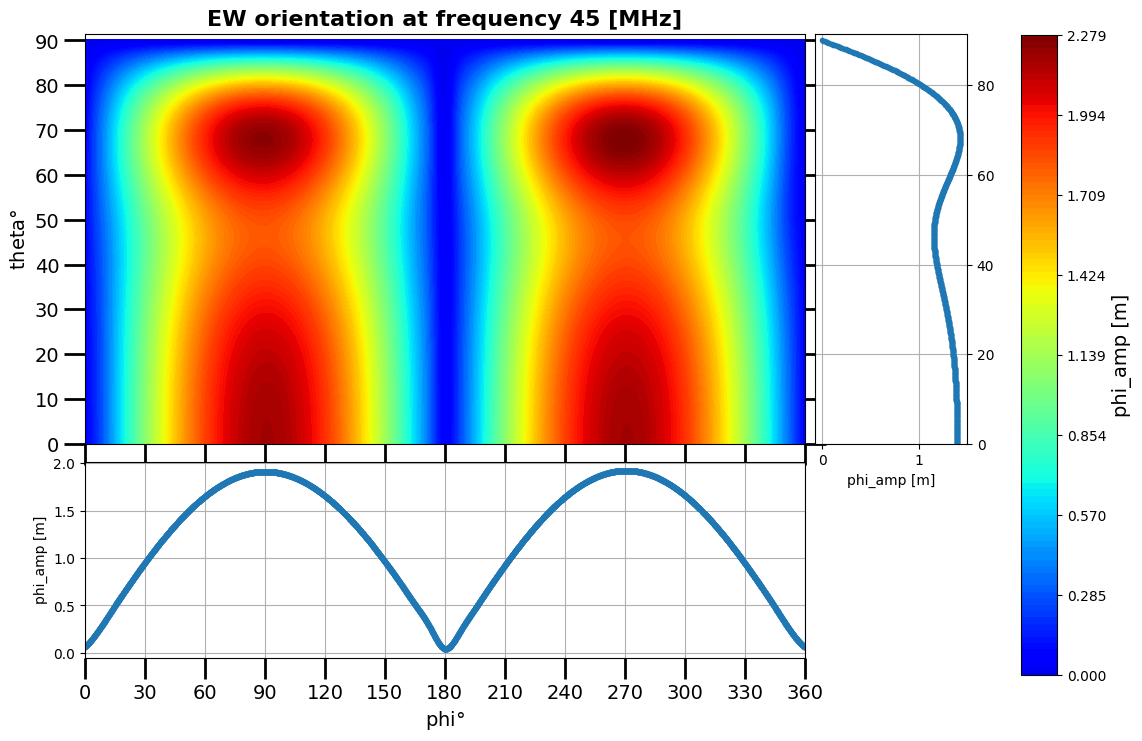

In [16]:
incTheta = 0.1
incPhi = 0.1
newTheta = np.arange(0,90+incTheta,incTheta)
newPhi= np.arange(0,360+incPhi,incPhi)

# select frequency
frequency=45

# choose quantity
quantity = 'phi_amp'
# quantity = 'theta_amp'
# quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW

# select NS orientation
# orientation = 'NS'
# antenna=antennaNS

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'+'_thetaInterp_cubic'

# kind = linear, cubic etc. see scipy interp1d for options
Amp = antenna.get(quantity=quantity, frequency=frequency, newTheta=newTheta, newPhi=newPhi, kind='cubic', changeConvention=False, orientation='EW')

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30, yMajorLocator=10, figureWidth=12, figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save, close=close)

### Plot of antenna pattern quantity Q at frequency F with the changed convention
Change from the Offline azimuth convention to -180$^{\circ}$ and 180$^{\circ}$ azimuth with North at 0$^{\circ}$  and East at 90$^{\circ}$, West at -90$^{\circ}$ and from zenith to altitude. Or in other words, from Offline convention to healpy internal standard.

cmap.T:  256
tmins:  3.6454906805153474e-11  tmax:  1.6113411151012333  Tstep:  9
cbarTicks:  [3.64549068e-11 2.01417639e-01 4.02835279e-01 6.04252918e-01
 8.05670558e-01 1.00708820e+00 1.20850584e+00 1.40992348e+00
 1.61134112e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/EW_absHeight_45Mhz


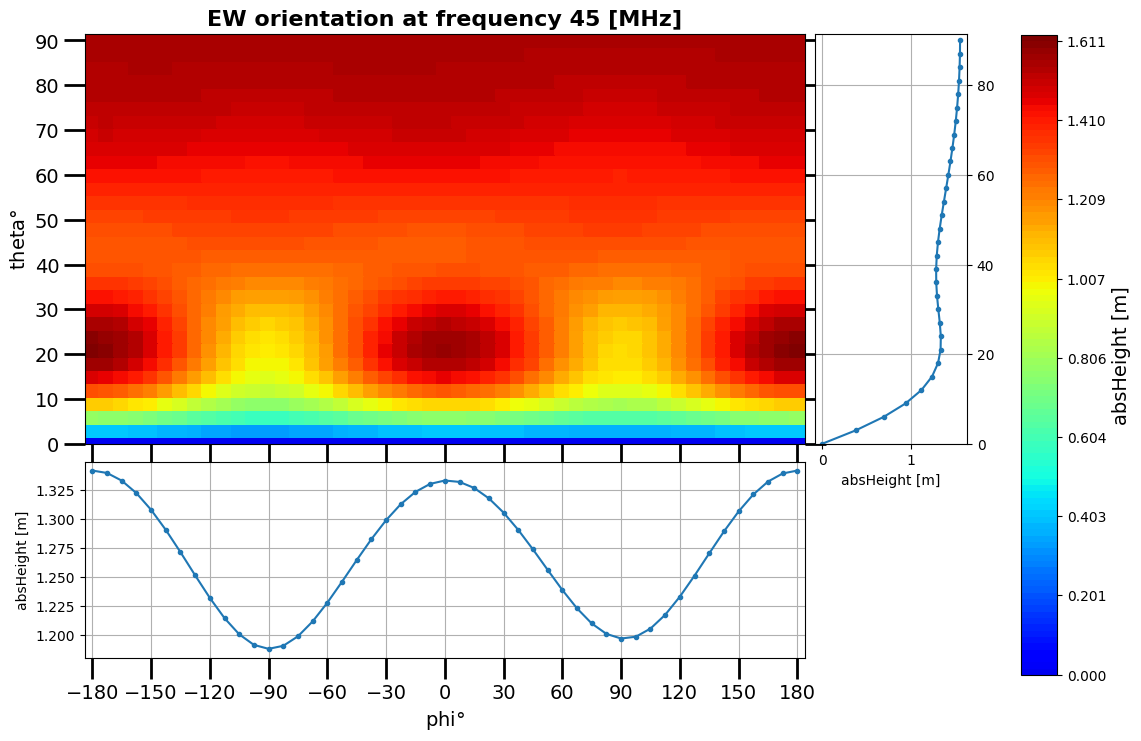

In [17]:
# select frequency
frequency=45

# choose quantity
# quantity = 'phi_amp'
# quantity = 'theta_amp'
quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW

# select NS orientation
# orientation = 'NS'
# antenna=antennaNS

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'

# changeConvention=True,orientation='EW', EW and NS has to be treated differently since both are in Offline align to North
Amp = antenna.get(quantity=quantity, frequency=frequency, changeConvention=True, orientation='EW')


P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T, slices=True, ymax=91.5, xMajorLocator=30, yMajorLocator=10, figureWidth=12, figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

### Plot of antenna pattern quantity Q at frequency F with the changed convention with interpolated values
This is the most usefull for the real work. We need to change the Offline convention to healpy convention with properly rotated NS antenna with a custom angle spacing.

cmap.T:  256
tmins:  3.6446405913364005e-11  tmax:  1.6131864259431856  Tstep:  9
cbarTicks:  [3.64464059e-11 2.01648303e-01 4.03296607e-01 6.04944910e-01
 8.06593213e-01 1.00824152e+00 1.20988982e+00 1.41153812e+00
 1.61318643e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/EW_absHeight_45Mhz_thetaInterp_cubic


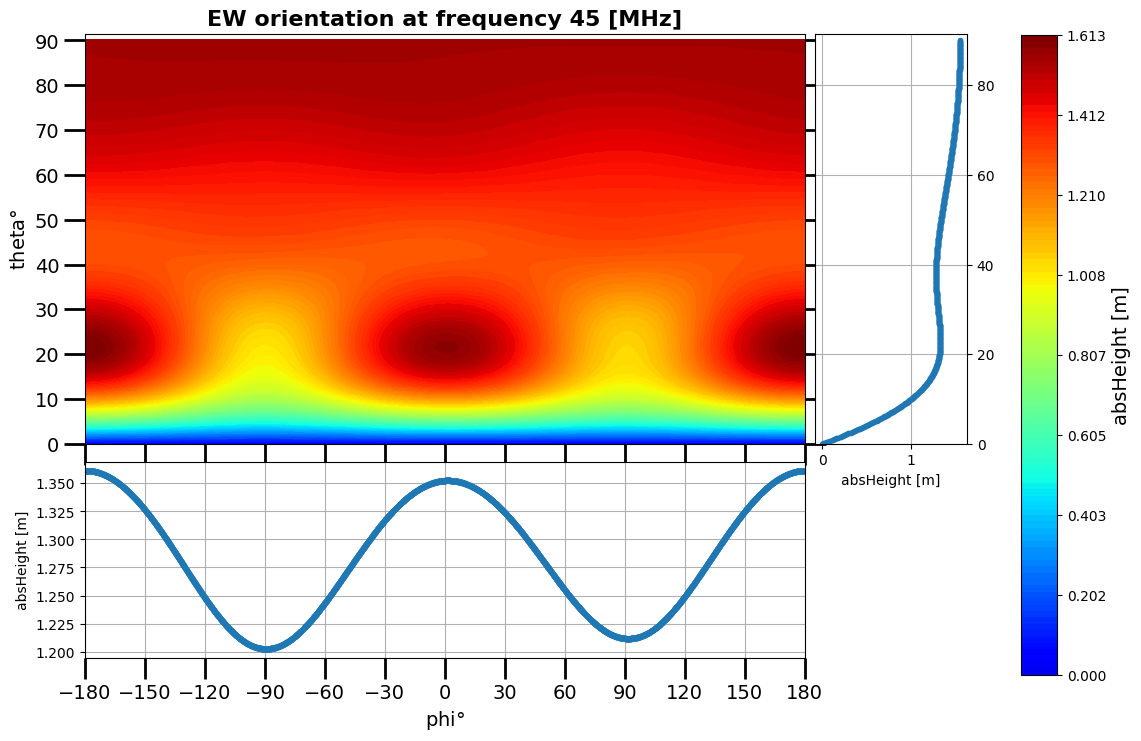

cmap.T:  256
tmins:  3.450431072343851e-11  tmax:  1.5268544229343366  Tstep:  9
cbarTicks:  [3.45043107e-11 1.90856803e-01 3.81713606e-01 5.72570409e-01
 7.63427211e-01 9.54284014e-01 1.14514082e+00 1.33599762e+00
 1.52685442e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/NS_absHeight_45Mhz_thetaInterp_cubic


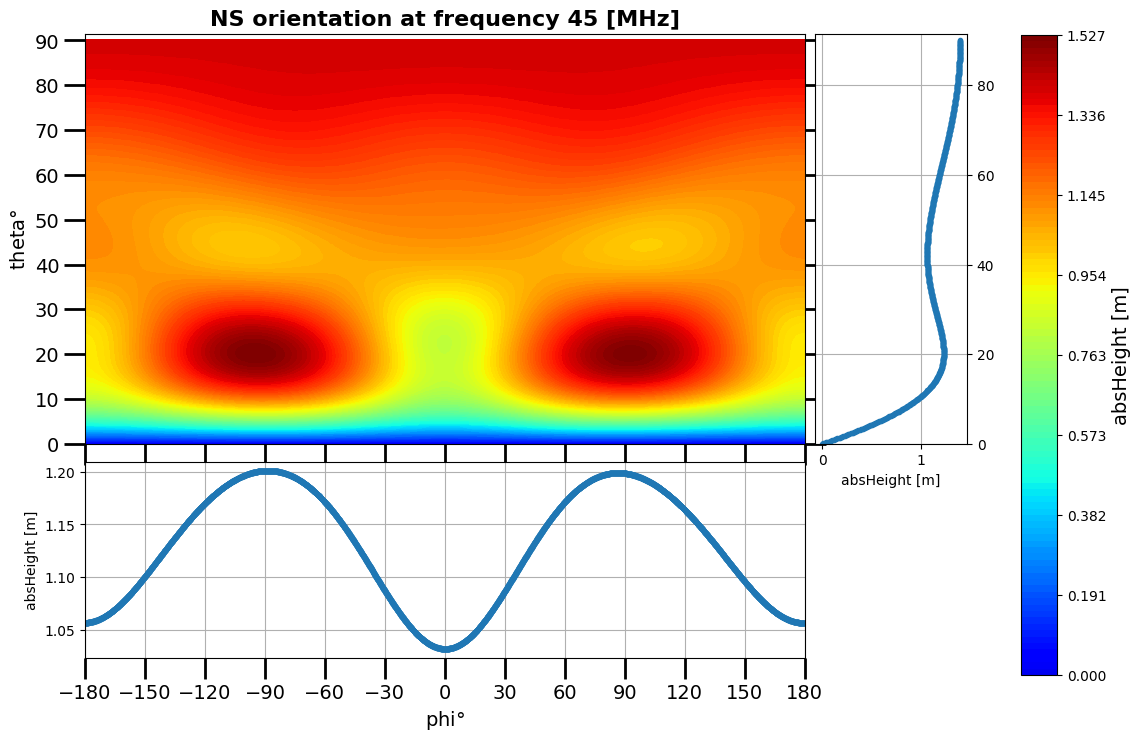

In [18]:
incTheta = 0.1
incPhi = 0.1
newTheta = np.arange(0,90+incTheta,incTheta)
newPhi= np.arange(-180,180+incPhi,incPhi)

# select frequency
frequency=45

# choose quantity
# quantity = 'phi_amp'
# quantity = 'theta_amp'
quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'+'_thetaInterp_cubic'

# changeConvention=True,orientation='EW', EW and NS has to be treated differently since both are in Offline align to North
Amp = antenna.get(quantity=quantity, frequency=frequency, changeConvention=True, orientation=orientation, newTheta=newTheta, newPhi=newPhi,kind='cubic')

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30, yMajorLocator=10, figureWidth=12, figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

# select NS orientation
orientation = 'NS'
antenna=antennaNS

# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'+'_thetaInterp_cubic'

Amp = antenna.get(quantity=quantity, frequency=frequency, changeConvention=True, orientation=orientation, newTheta=newTheta, newPhi=newPhi, kind='cubic')

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30, yMajorLocator=10, figureWidth=12, figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

# Radio sky temperature map simulations

<font size="5">Import necessery modules</font>

In [19]:
# healpy as the manipulation tool
import healpy as hp
# the upgraded newvisufunc is not yet in the official release
# current it is a pull request https://github.com/healpy/healpy/pull/648
from healpy import newvisufunc

In [20]:
# import pyGDSM module
sys.path.append("/workdata/LFSS")
from pygdsm import GlobalSkyModel2016, GlobalSkyModel, LowFrequencySkyModel

Import Polisensky's LFmap as a class  (you need to run the script LFmap_healpyFitsConvertorAndGenerator.py inside the LFmap software folder to generate and convert the fits format to healpy fits format).<br>
Note please, that Polisensky's LFmap, these are by default generated in Celestial coordinated.

<font size="5">Set path to the LFmap folder:</font>

In [21]:
LFmapPath='/home/max/auger/soft/LFmap_1.0/'

In [22]:
class LFmap():
    def __init__(self, path):
        self._path=path
    def generate(self,frequency):
        return hp.read_map(self._path+"LFmap_"+str(frequency)+"_healpy.fits",verbose=True)

Create the sky temperature map classes for both references.

In [23]:
# for Polisensky's LFmap
g_LFmap = LFmap(LFmapPath+"/healpyFits/")
# for lf map from pygdsem
g_LFSS = LowFrequencySkyModel(freq_unit='MHz')

## Examples
For more examples check the notebook dedicated for this (skyMapExamples)

First generate maps at some frequency (for example 45 MHz). Please write the frequency in the format with the decimal. The class for LFmap is searching for the correct map by use of the filename.

In [24]:
map_LFSS = np.log10(g_LFSS.generate(45.0))
map_LFSS_title = "LFSS"
map_LFmap = np.log10(g_LFmap.generate(45.0))
map_LFmap_title = "LFmap"

###  Maps in Galactic coordinates
Also you can check other possible projections, like cart, hammer etc. Check skyMapExample notebook for this.

mollweide
mollweide


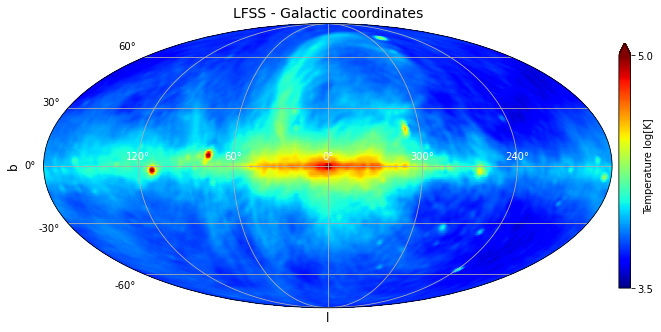

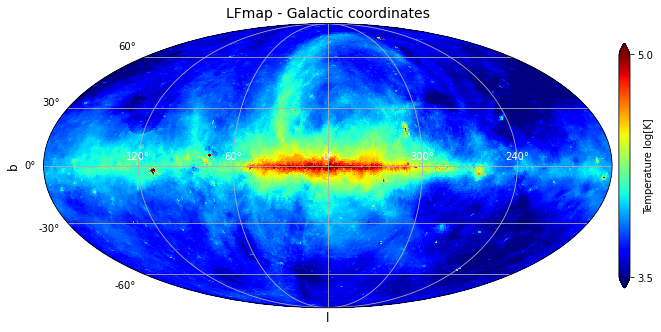

In [25]:
# mollweide projections
newvisufunc.projview(map_LFSS, coord=['G'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='l',ylabel='b',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="mollweide",title=map_LFSS_title+" - Galactic coordinates",lcolor='white')

newvisufunc.projview(map_LFmap, coord=['C','G'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='l',ylabel='b',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="mollweide",title=map_LFmap_title+" - Galactic coordinates",lcolor='white')

###  Transformation to the Local coordinates system

Rotate the maps to PAO local coordinates at the some particular LST time.

In [26]:
# PAO altitude is -35.206667 degs
LSTtime=18
altitude = -35.206667

Transform the coordinates and make the plots.

cart
cart


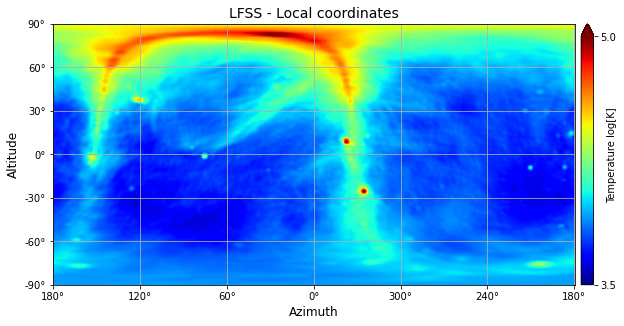

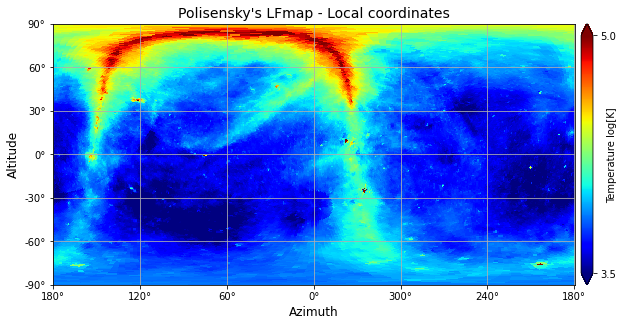

In [27]:
# Local coordinates at LST time "LSTtime" at altitude "altitude"
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
newvisufunc.projview(map_LFSS,rot=rotAngles, coord=['G','C'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='Azimuth',ylabel='Altitude',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="cart",title='LFSS - Local coordinates',lcolor='white')

newvisufunc.projview(map_LFmap, rot=rotAngles, coord=['C'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='Azimuth',ylabel='Altitude',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="cart",title="Polisensky's LFmap - Local coordinates",lcolor='white')
#The default is to measure azimuth East from North
# 0 is north 90 is east 180 is souht, 270 is west

### Data dump and DataFrame creation
An example of how to dump the data from the maps. This is very important because later we need to convolute the sky temperature maps with the antenna pattern. Always check the dump data by plotting them (for example with function myPlots.plot3d()). <br>
The data dump will return three variables: <br>
longitude, latitude, grid_map <br>
where the longtitude goes from -pi to pi (-180 to 180 in degs) and the latitude goes from -pi/2 to pi/2 (-90$^\circ$ to 90$^\circ$) <br>
Longitude and latitude are 1D arrays, to convert them to 2D arrays for the plot use np.meshgrid(longitude,  latitude)

In [28]:
# return only data
# [longitude,  latitude, grid_map]
# longitude,  latitude are 1D arrays to convert them to 2D arrays for the plot use np.meshgrid(longitude,  latitude)
# longtitude goes from -pi to pi (-180 to 180 in degs)
# latitude goes from -pi/2 to pi/2 (-90 to 90 in degs)
# generate maps at 45 MHz
# do not logarithm this here!
map_LFSS = g_LFSS.generate(45.0)
map_LFSS_title = "LFSS"
map_LFmap = g_LFmap.generate(45.0)
map_LFmap_title = "LFmap"

rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
longitude_LFSS,  latitude_LFSS, grid_map_LFSS = newvisufunc.projview(map_LFSS, rot=rotAngles, coord=['G','C'],
                                                      return_only_data=True)
longitude_LFmap,  latitude_LFmap, grid_map_LFmap = newvisufunc.projview(map_LFmap, rot=rotAngles, coord=['C'],
                                                      return_only_data=True)

Check the shapes of the dumped variables.

In [29]:
print(longitude_LFmap.shape)
print(latitude_LFmap.shape)
print(grid_map_LFmap.shape)

(1000,)
(500,)
(500, 1000)


Further, it is good to convert the dumped data to a proper Pandas DataFrame. The function <i>convert2SkyDF</i> will create a Pandas DataFrame from the dumped data with columns as frequencies and rows (index) as local sidereal times.

In [59]:
# this function helps to convert the data dump from newvisufunc.projview() to DF
def convert2SkyDF(data_dump,full=False):
    def DFtemplateCreator(xs,ys,yName=None):
        colList = [str(x) for x in xs]
        nan_init = np.empty((len(xs),len(ys),))
        nan_init[:]=np.nan
        templateDF = pd.DataFrame(nan_init.T, columns = colList)
        templateDF.insert(0,yName,ys)
        templateDF = templateDF.set_index(yName)
        return templateDF
    longitude,latitude,grid_map = data_dump
    latitudeDeg = np.rad2deg(latitude)
    longitudeDeg = np.rad2deg(longitude)
    skyMapDF = DFtemplateCreator(latitudeDeg,longitudeDeg,yName=None)
    skyMapDF.iloc[:,:] = grid_map.T
    if full is False:
        skyMapDF = skyMapDF.iloc[:,np.where(skyMapDF.columns.astype(float) >=0)[0].tolist()]
    skyMapDF=skyMapDF.sort_index()
    return skyMapDF

Define catalogs of all available radio sky interpolation models.

In [60]:
# for map from LFmap, these are by default generated in Celestial coordinated
model = {"LFmap": LFmap("/home/max/auger/soft/LFmap_1.0/healpyFits/"), "LFSM": LowFrequencySkyModel(freq_unit='MHz'), "GSM": GlobalSkyModel(freq_unit='MHz'), "GSM16": GlobalSkyModel2016(freq_unit='MHz')}
model_title = {"LFmap": "LFmap", "LFSM": "LFSM", "GSM": "GSM2008", "GSM16": "GSM2016"}
g_model_coord = {"LFmap": ['C','G'], "LFSM": ['G'], "GSM": ['G'], "GSM16": ['G']}
c_model_coord = {"LFmap": ['C'], "LFSM": ['G','C'], "GSM": ['G','C'], "GSM16": ['G','C']}
e_model_coord = {"LFmap": ['C','E'], "LFSM": ['G','E'], "GSM": ['G','E'], "GSM16": ['G','E']}
model_scale = {"LFmap": 256, "LFSM": 16, "GSM": 4, "GSM16": 1}

#choose sky models from: LFmap, LFSM, GSM, GSM16
key1 = "LFSM"
key2 = "GSM"

g_1 = model[key1]
g_2 = model[key2]
g_coord_1 = g_model_coord[key1]
g_coord_2 = g_model_coord[key2]
c_coord_1 = c_model_coord[key1]
c_coord_2 = c_model_coord[key2]
e_coord_1 = e_model_coord[key1]
e_coord_2 = e_model_coord[key2]
model_scale_1 = model_scale[key1]
model_scale_2 = model_scale[key2]

First generate the data.

In [67]:
# generate sky maps
frequency = 30.0
map_1 = g_1.generate(frequency)
map_1_title = model_title[key1]
map_2 = g_2.generate(frequency)
map_2_title = model_title[key2]

# Colormap ranges for log scales
Tmin = 3.5
Tmax = 5.0

Dump the data.

In [62]:
# dump maps in Galactic coordinate system
dumpG_1 = newvisufunc.projview(map_1,coord=g_coord_1, return_only_data=True)
dumpG_2 = newvisufunc.projview(map_2,coord=g_coord_2, return_only_data=True)

Then convert the data dump to DataFrame.

In [63]:
# then convert the data dump to DataFrame
# set full=True to have full Y axis
GskyMapDF_1=convert2SkyDF(dumpG_1,full=True)
GskyMapDF_2=convert2SkyDF(dumpG_2,full=True)

Check the created DataFrame.

In [64]:
GskyMapDF_1

-90.0  -89.63927855711424  -89.27855711422846  \
-180.000000  13752.490778        13704.084755        13686.167803   
-179.639640  13875.673832        13826.339712        13782.947398   
-179.279279  13875.673832        13826.339712        13782.947398   
-178.918919  13875.673832        13826.339712        13782.947398   
-178.558559  13875.673832        13826.339712        13782.947398   
...                   ...                 ...                 ...   
 178.558559  13752.490778        13704.084755        13686.167803   
 178.918919  13752.490778        13704.084755        13686.167803   
 179.279279  13752.490778        13704.084755        13686.167803   
 179.639640  13752.490778        13704.084755        13686.167803   
 180.000000  13752.490778        13704.084755        13686.167803   

             -88.91783567134269  -88.55711422845691  -88.19639278557115  \
-180.000000        13703.157162        13764.431654        13831.426272   
-179.639640        13790.541624        13857.063020        13929.263646   
-179.279279        13790.541624        13857.063020        13929.263646   
-178.918919        13790.541624        13857.063020        13929.263646   
-178.558559        13790.541624        13857.063020        13929.263646   
...                         ...                 ...                 ...   
 178.558559        13703.157162        13764.431654        13831.426272   
 178.918919        13703.157162        13764.431654        13831.426272   
 179.279279        13703.157162        13764.431654        13831.426272   
 179.639640        13703.157162        13764.431654        13831.426272   
 180.000000        13703.157162        13764.431654        13831.426272   

             -87.83567134268537  -87.4749498997996  -87.11422845691382  \
-180.000000        13876.590606       13891.715179        13874.192304   
-179.639640        13972.018728       13975.989054        13955.138865   
-179.279279        13972.018728       13975.989054        13955.138865   
-178.918919        13972.018728       13975.989054        13955.138865   
-178.558559        13972.018728       13975.989054        13955.138865   
...                         ...                ...                 ...   
 178.558559        13876.590606       13891.715179        13874.192304   
 178.918919        13876.590606       13891.715179        13874.192304   
 179.279279        13876.590606       13891.715179        13874.192304   
 179.639640        13876.590606       13891.715179        13874.192304   
 180.000000        13876.590606       13891.715179        13874.192304   

             -86.75350701402806  ...  86.75350701402806  87.11422845691385  \
-180.000000        13840.159744  ...       14155.007943       14254.398356   
-179.639640        13936.267298  ...       14141.467373       14227.112614   
-179.279279        13936.267298  ...       14141.467373       14227.112614   
-178.918919        13936.267298  ...       14141.467373       14227.112614   
-178.558559        13936.267298  ...       14141.467373       14227.112614   
...                         ...  ...                ...                ...   
 178.558559        13840.159744  ...       14155.007943       14254.398356   
 178.918919        13840.159744  ...       14155.007943       14254.398356   
 179.279279        13840.159744  ...       14155.007943       14254.398356   
 179.639640        13840.159744  ...       14155.007943       14254.398356   
 180.000000        13840.159744  ...       14155.007943       14254.398356   

             87.47494989979961  87.83567134268537  88.19639278557116  \
-180.000000       14305.558540       14344.946589       14432.238112   
-179.639640       14247.359485       14281.471127       14396.554273   
-179.279279       14247.359485       14281.471127       14396.554273   
-178.918919       14247.359485       14281.471127       14396.554273   
-178.558559       14247.359485       14281.471127       14396.554273   
...                        ...  

Plot the data from the DataFrame and compare the maps by dividing one by the other one.

mollweide
mollweide


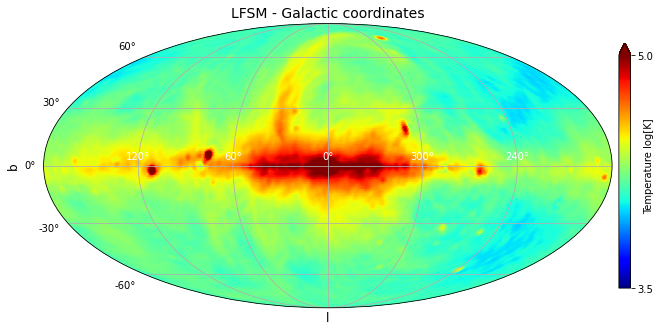

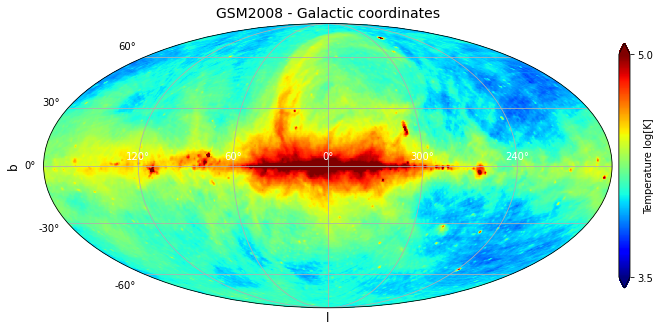

In [68]:
# mollweide projections
newvisufunc.projview(np.log10(map_1), coord=g_coord_1,graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='l',ylabel='b',
                    cb_orientation='vertical',min=Tmin,max=Tmax,latitude_grid_spacing=30,
                    projection_type="mollweide",title=map_1_title+" - Galactic coordinates",lcolor='white')

newvisufunc.projview(np.log10(map_2), coord=g_coord_2,graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='l',ylabel='b',
                    cb_orientation='vertical',min=Tmin,max=Tmax,latitude_grid_spacing=30,
                    projection_type="mollweide",title=map_2_title+" - Galactic coordinates",lcolor='white')

### Comparison of the 1st map with the 2nd map at Local Coordinates

cmap.T:  256
tmins:  3.0  tmax:  5.0  Tstep:  9
cbarTicks:  [3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/GskyMapDF_LFSM_30_0


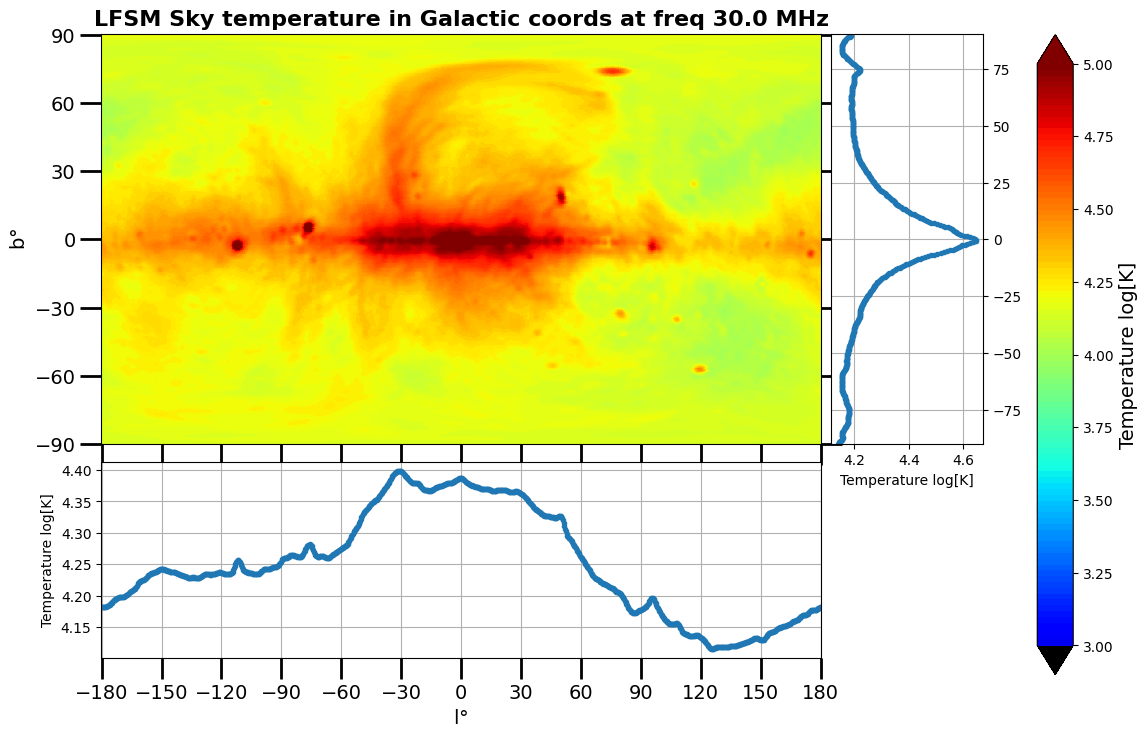

cmap.T:  256
tmins:  3.0  tmax:  5.0  Tstep:  9
cbarTicks:  [3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/GskyMapDF_GSM2008_30_0


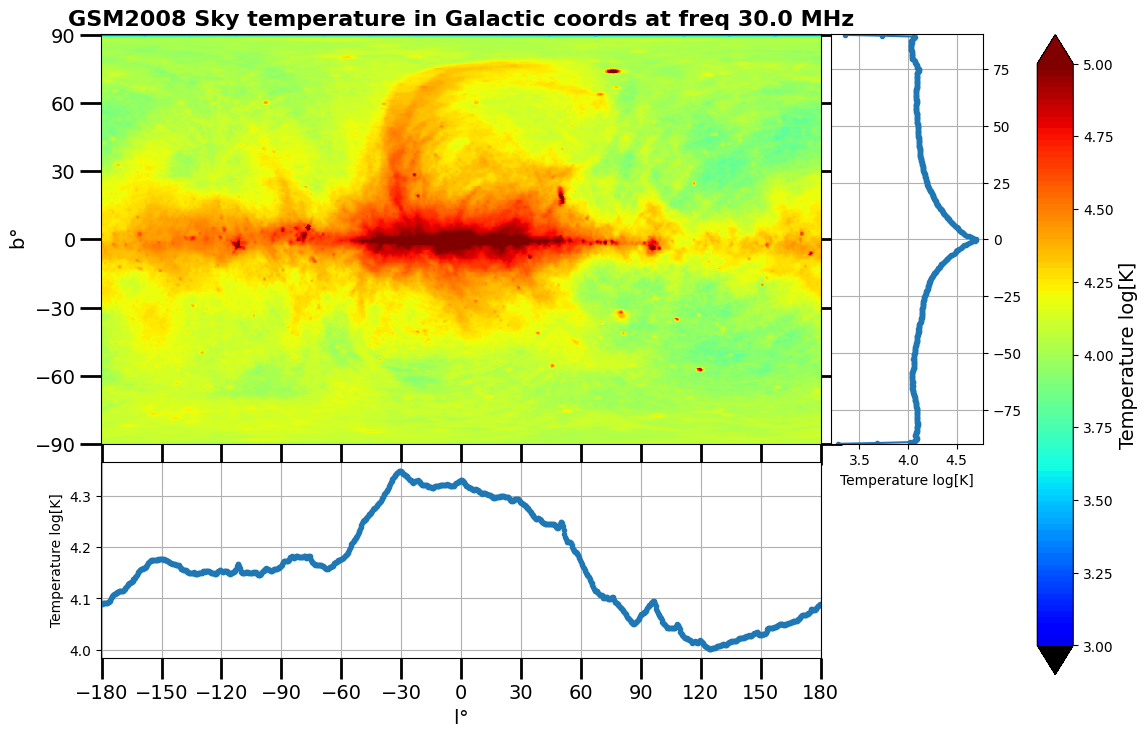

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_GskyMapDF_LFSM-GskyMapDF_GSM2008_30_0


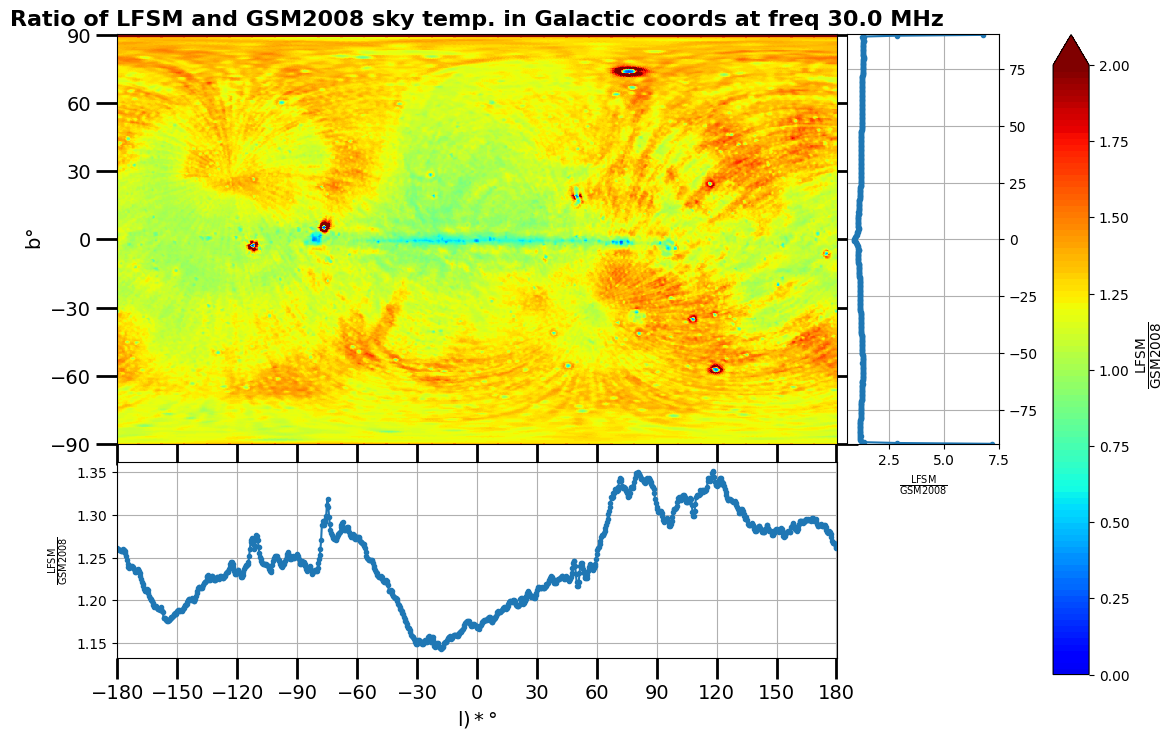

cmap.T:  256
tmins:  -14.179649240339769  tmax:  11.747211218147035  Tstep:  9
cbarTicks:  [-14.17964924 -10.93879168  -7.69793413  -4.45707657  -1.21621901
   2.02463855   5.2654961    8.50635366  11.74721122]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/nonAbs_Difference_GskyMapDF_LFSM-GskyMapDF_GSM2008_30_0


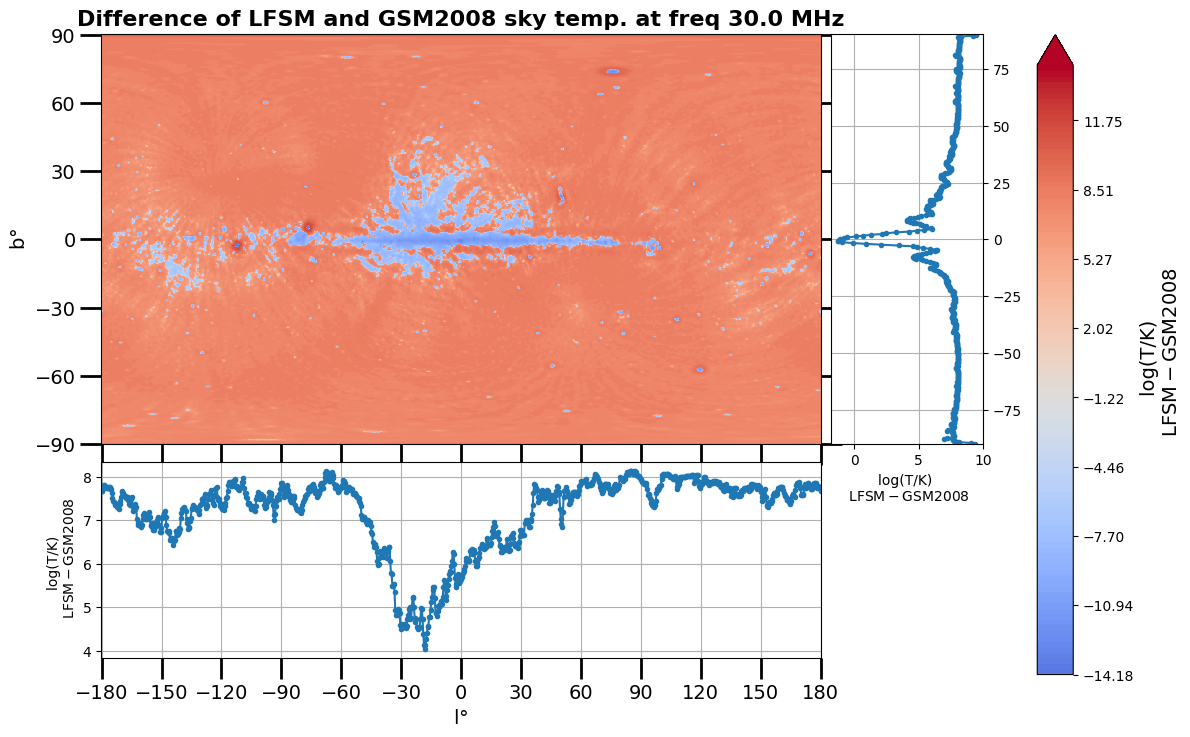

cmap.T:  256
tmins:  -3.9445955088288622  tmax:  14.179649240339769  Tstep:  9
cbarTicks:  [-3.94459551 -1.67906492  0.58646568  2.85199627  5.11752687  7.38305746
  9.64858805 11.91411865 14.17964924]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Abs_Difference_GskyMapDF_LFSM-GskyMapDF_GSM2008_30_0


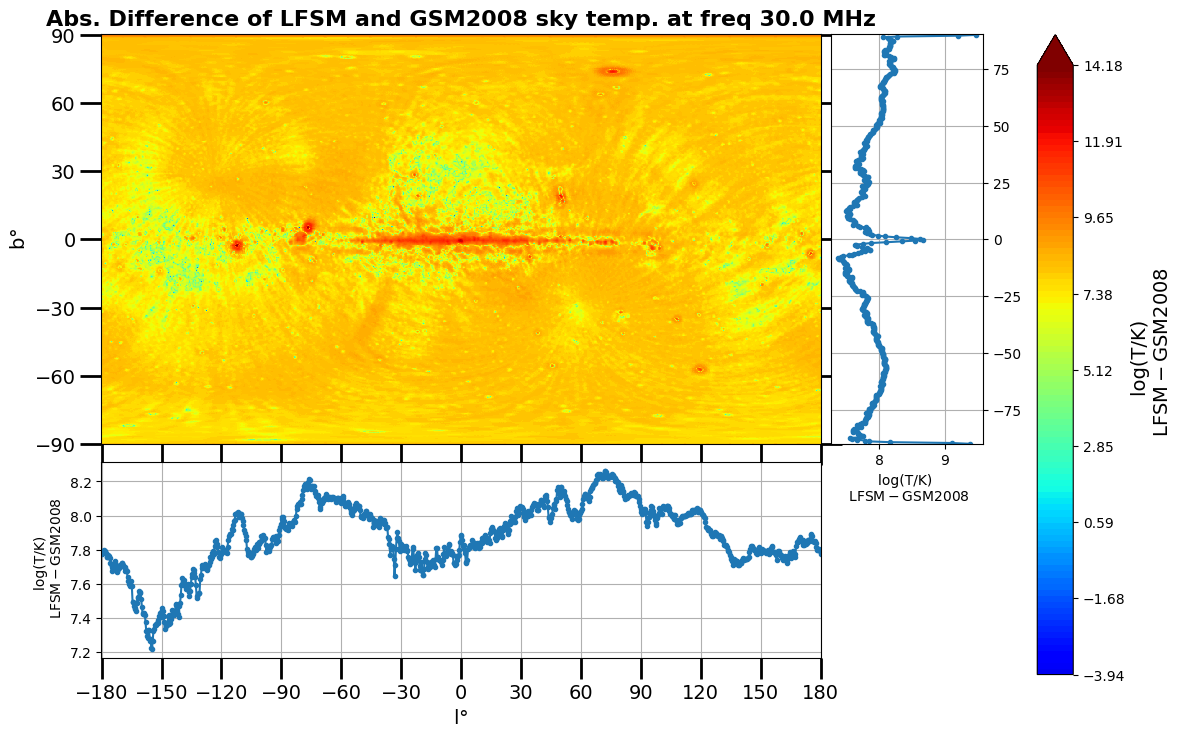

In [66]:
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float), GskyMapDF_1.columns.values.astype(float))

save=False
save1= saveFolder+"GskyMapDF_"+map_1_title+'_'+str(frequency).replace('.','_')
save2= saveFolder+"GskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')
save3= saveFolder+"Ratio_GskyMapDF_"+map_1_title+"-GskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')
save4=saveFolder+"nonAbs_Difference_GskyMapDF_"+map_1_title+"-GskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')
save5=saveFolder+"Abs_Difference_GskyMapDF_"+map_1_title+"-GskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')

# log here!
myPlots.plot3dnewV3(P, T, np.log10(GskyMapDF_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30, figureWidth=12, figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel='Temperature log[K]',
                    mainTitle=map_1_title+" Sky temperature in Galactic coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,extend='both',
                    save=save1,close=close)

P, T = np.meshgrid(GskyMapDF_2.index.values.astype(float),GskyMapDF_2.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, np.log10(GskyMapDF_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30, figureWidth=12, figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel='Temperature log[K]',
                    mainTitle=map_2_title+" Sky temperature in Galactic coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,extend='both',
                    save=save2,close=close)

ratio=GskyMapDF_1.values.T/GskyMapDF_2.values.T
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float),GskyMapDF_1.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30, figureWidth=12, figureHeight=8,
                    xlabel='l$)*\degree$',ylabel='b$\degree$',cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" sky temp. in Galactic coords at freq "+str(frequency)+' MHz',Cmin=0,Cmax=2,extend='max',
                    save=save3,close=close)

difference=np.sign(GskyMapDF_1.values.T-GskyMapDF_2.values.T)*np.log(abs(GskyMapDF_1.values.T-GskyMapDF_2.values.T))
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float),GskyMapDF_1.columns.values.astype(float))
myPlots.plot3dnewV4(P, T, difference,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30,figureWidth=12,figureHeight=8, Cmap='coolwarm',
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel='log(T/K) \n '+r'${\mathrm{%s}}-{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Difference of "+map_1_title+" and "+map_2_title+" sky temp. at freq "+str(frequency)+' MHz',extend='max',
                    save=save4,close=close)

Abs_difference=np.log(abs(GskyMapDF_1.values.T-GskyMapDF_2.values.T))
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float),GskyMapDF_1.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Abs_difference,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30,figureWidth=12,figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel='log(T/K) \n '+r'${\mathrm{%s}}-{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Abs. Difference of "+map_1_title+" and "+map_2_title+" sky temp. at freq "+str(frequency)+' MHz',extend='max',
                    save=save5,close=close)

Dump the maps transfomed to a local coordinates.

In [69]:
# PAO altitude is -35.206667 degs
LSTtime=18
altitude = -35.206667

In [70]:
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,
                                                      return_only_data=True, xsize=newPhi.size)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2,
                                                      return_only_data=True, xsize=newPhi.size)

Then convert the data dumps to the DataFrames.

In [71]:
LskyMapDF_1=convert2SkyDF(dump_1,full=False)
LskyMapDF_2=convert2SkyDF(dump_2,full=False)

Plot the data from the DataFrame and compare the maps by dividing one by the other one.

cmap.T:  256
tmins:  3.5  tmax:  5.0  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/LskyMapDF_LFSM_30_0


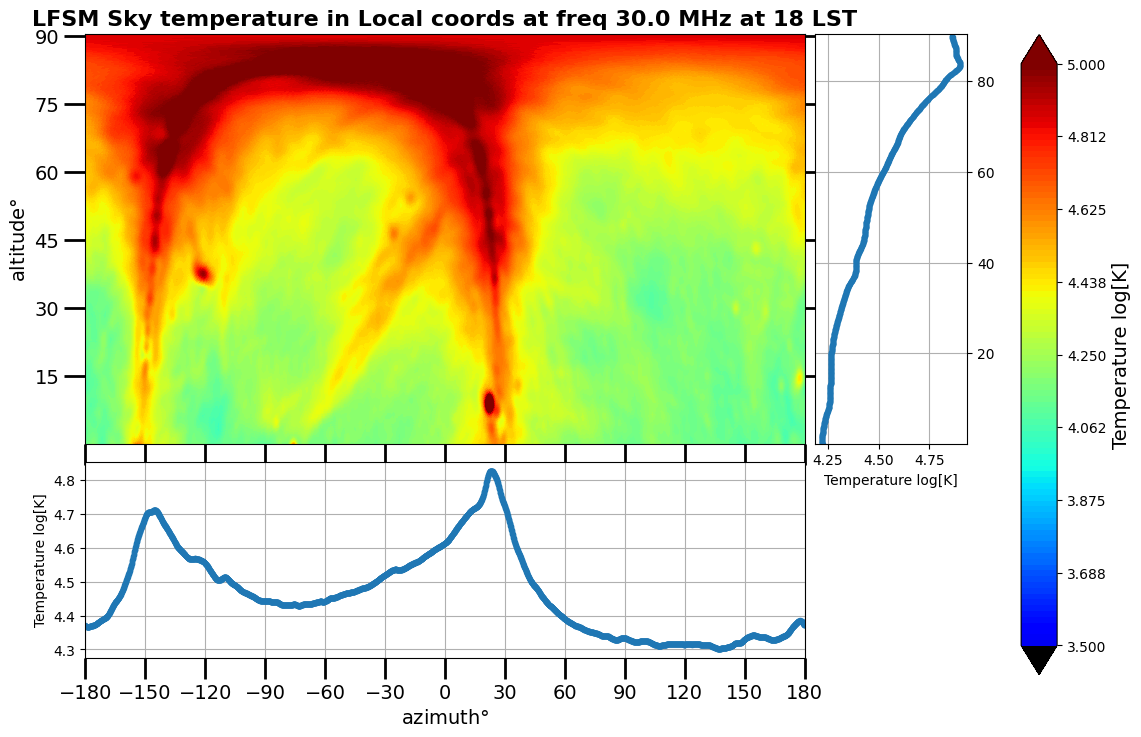

cmap.T:  256
tmins:  3.5  tmax:  5.0  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/LskyMapDF_GSM2008_30_0


cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_LskyMapDF_LFSM-LskyMapDF_GSM2008_30_0


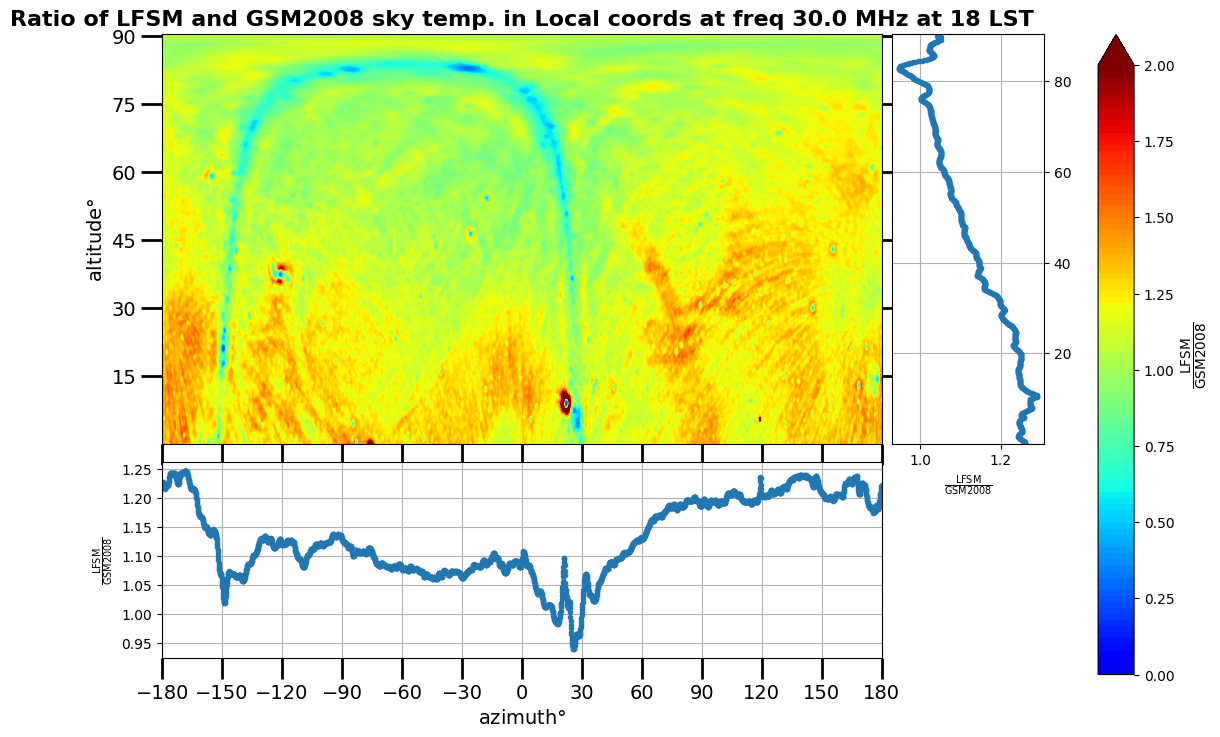

In [72]:
P, T = np.meshgrid(LskyMapDF_1.index.values.astype(float), LskyMapDF_1.columns.values.astype(float))

save=False
save1=saveFolder+"LskyMapDF_"+map_1_title+'_'+str(frequency).replace('.','_')
save2=saveFolder+"LskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')
save3=saveFolder+"Ratio_LskyMapDF_"+map_1_title+"-LskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')

# log here!
myPlots.plot3dnewV3(P, T, np.log10(LskyMapDF_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_1_title+" Sky temperature in Local coords at freq "+str(frequency)+' MHz at '+str(LSTtime)+" LST",Cmin=Tmin,Cmax=Tmax,
                    save=save1, close=close)

myPlots.plot3dnewV3(P, T, np.log10(LskyMapDF_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_2_title+" Sky temperature in Local coords at freq "+str(frequency)+' MHz at '+str(LSTtime)+" LST",Cmin=Tmin,Cmax=Tmax,
                    save=save2, close=close)

ratio=LskyMapDF_1.values.T/LskyMapDF_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" sky temp. in Local coords at freq "+str(frequency)+' MHz at '+str(LSTtime)+" LST",
                    Cmin=0, Cmax=2, extend='max', save=save3,close=close)

## Plot Maps in Equatorial Coordinates

In [73]:
LSTtime = 0.
rotAngles=[((LSTtime*15))%360,0]
dump_1 = newvisufunc.projview(map_1, coord=e_coord_1, return_only_data=True, xsize=newPhi.size)
dump_2 = newvisufunc.projview(map_2, coord=e_coord_2, return_only_data=True, xsize=newPhi.size)
#dump_1 = newvisufunc.projview(map_1, rot=rotAngles, coord=e_coord_1, return_only_data=True, xsize=newPhi.size)
#dump_2 = newvisufunc.projview(map_2, rot=rotAngles, coord=e_coord_2, return_only_data=True, xsize=newPhi.size)

Then convert the data dumps to the DataFrames.

In [74]:
EskyMapDF_1=convert2SkyDF(dump_1,full=True)
EskyMapDF_2=convert2SkyDF(dump_2,full=True)

In [75]:
def markCoverage(SkyMap, decl_min=-90., decl_max=90.):
    p = np.deg2rad(SkyMap.index.values.astype(float))
    t = np.deg2rad(SkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    val = np.where(np.logical_and(T >= np.deg2rad(decl_min), T <= np.deg2rad(decl_max)), SkyMap.values, 0.)
    map_cut = pd.DataFrame(val, p, t)
    return map_cut

In [76]:
EskyMapDF_1_coverage = markCoverage(EskyMapDF_1, -40, 90)
EskyMapDF_2_coverage = markCoverage(EskyMapDF_2, -40, 90)

In [220]:
# add a sun to the sky at any point (with right ascension+declination) with a uniform temperature and with an angular size in units of sunradii
def addSun(SkyMap, RA=180., decl=0., Temp=45000., radius=0.25):
    p = np.deg2rad(SkyMap.index.values.astype(float))
    t = np.deg2rad(SkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    s = np.vstack(([T.T],[(P+np.pi).T])).T
    #s2 = np.arccos(np.sin(np.rad2deg(s[...,0]))*np.sin(np.rad2deg(decl))+np.cos(np.rad2deg(s[...,0]))*np.cos(np.rad2deg(decl))*np.cos(np.rad2deg(s[...,1]-RA)))
    s2 = np.arccos(np.sin(s[...,0])*np.sin(decl)+np.cos(s[...,0])*np.cos(decl)*np.cos(s[...,1]-RA))
    val = np.where(s2 < np.deg2rad(radius), Temp, SkyMap.values)
    print(sum(sum(np.where(s2 < np.deg2rad(radius),1,0)))," pixels covered by the sun")
    map_with_sun = pd.DataFrame(val, p, t)
    return map_with_sun

In [229]:
EskyMapDF_1_sun = addSun(EskyMapDF_1, radius=100.*0.25)

197886  pixels covered by the sun


In [230]:
from importlib import reload
reload(myPlots)

<module 'myPlots' from '/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py'>

Plot the data from the DataFrame and compare the maps by dividing one by the other one.

cmap.T:  256
tmins:  3.5  tmax:  5.0  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/test/EskyMapDF_LFSM_30_0_sun


cmap.T:  256
tmins:  3.5  tmax:  5.0  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)


KeyboardInterrupt: 

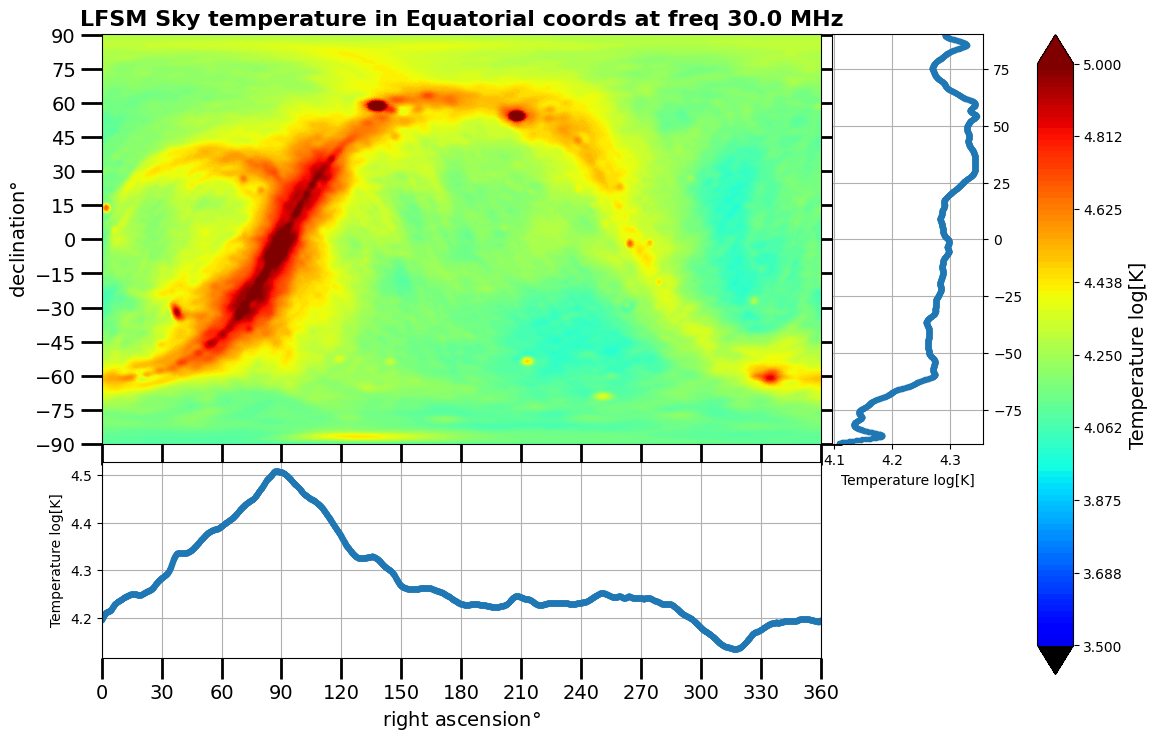

In [231]:
P, T = np.meshgrid(EskyMapDF_1.index.values.astype(float), EskyMapDF_1.columns.values.astype(float))

# Convert to Right Ascension (alpha)
P = -(P - 180.)

save=False
save1=saveFolder+"EskyMapDF_"+map_1_title+'_'+str(frequency).replace('.','_')
save1_sun=saveFolder+"EskyMapDF_"+map_1_title+'_'+str(frequency).replace('.','_')+'_sun'
save1_coverage=saveFolder+"EskyMapDF_"+map_1_title+'_'+str(frequency).replace('.','_')+'_coverage'
save2=saveFolder+"EskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')
save2_coverage=saveFolder+"EskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')+'_coverage'
save3=saveFolder+"Ratio_EskyMapDF_"+map_1_title+"-EskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')

# log here!
myPlots.plot3dnewV3(P, T, np.log10(EskyMapDF_1_sun.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='right ascension$\degree$',ylabel='declination$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_1_title+" Sky temperature in Equatorial coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,
                    save=save1_sun, close=close)

myPlots.plot3dnewV3(P, T, np.log10(EskyMapDF_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='right ascension$\degree$',ylabel='declination$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_1_title+" Sky temperature in Equatorial coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,
                    save=save1, close=close)

myPlots.plot3dnewV3(P, T, np.log10(EskyMapDF_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8, Blind_min=-90, Blind_max=-40,
                    xlabel='right ascension$\degree$',ylabel='declination$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_1_title+" Sky temperature in Equatorial coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,
                    save=save1_coverage, close=close)

myPlots.plot3dnewV3(P, T, np.log10(EskyMapDF_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='right ascension$\degree$',ylabel='declination$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_2_title+" Sky temperature in Equatorial coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,
                    save=save2, close=close)

myPlots.plot3dnewV3(P, T, np.log10(EskyMapDF_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8, Blind_min=-90, Blind_max=-40,
                    xlabel='right ascension$\degree$',ylabel='declination$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_2_title+" Sky temperature in Equatorial coords at freq "+str(frequency)+' MHz',Cmin=Tmin,Cmax=Tmax,
                    save=save2_coverage, close=close)

ratio=EskyMapDF_1.values.T/EskyMapDF_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='right ascension$\degree$', ylabel='declination$\degree$', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" sky temp. in Equatorial coords at freq "+str(frequency)+' MHz',
                    Cmin=0, Cmax=2, extend='max', save=save3,close=close)

# Calculate average temperature of global & local sky at all frequencies 

Function to integrate over the sky for averaging.

In [233]:
# integrate the folded sky map over the angles
def integrateOverAngles_cos(SkyMap, t_min=-90, t_max=90):
    p = np.deg2rad(SkyMap.index.values.astype(float))
    t = np.deg2rad(SkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    #print(t[0],t[-1])
    angePrefactor=np.cos(T[:,::-1])
    angePrefactor = np.where(np.logical_and(t >= np.deg2rad(t_min), t <= np.deg2rad(t_max)), angePrefactor, 0.)
    #angePrefactor=1
    integratedOverAngles=simps(simps(SkyMap*angePrefactor,t),p)
    return integratedOverAngles

In [236]:
saveFolder='./results/skySimulation/'
#saveFolder='./results/skySimulation/test'
#saveFolder='./results/skySimulation/Coverage_test/'

# for testing different LFmap parameters
#saveFolder='./results/skySimulation/LFmap_test/'

Calculate average temperatures with required precision.

In [235]:
g = model['LFSM']
map = g.generate(30.)

dumpG = newvisufunc.projview(map,coord=g_model_coord['LFSM'], return_only_data=True)
GskyMapDF=convert2SkyDF(dumpG,full=True)
print(integrateOverAngles_cos(GskyMapDF, t_min=-90, t_max=45)/integrateOverAngles_cos(GskyMapDF/GskyMapDF, t_min=-90, t_max=45))
print(integrateOverAngles_cos(GskyMapDF, t_min=-90, t_max=90)/integrateOverAngles_cos(GskyMapDF/GskyMapDF, t_min=-90, t_max=90))

dumpE = newvisufunc.projview(map,coord=e_model_coord['LFSM'], return_only_data=True)
EskyMapDF=convert2SkyDF(dumpE,full=True)
print(integrateOverAngles_cos(EskyMapDF, t_min=-90, t_max=45)/integrateOverAngles_cos(EskyMapDF/EskyMapDF, t_min=-90, t_max=45))
print(integrateOverAngles_cos(EskyMapDF, t_min=-90, t_max=90)/integrateOverAngles_cos(EskyMapDF/EskyMapDF, t_min=-90, t_max=90))

dumpL = newvisufunc.projview(map,coord=c_model_coord['LFSM'], return_only_data=True)
LskyMapDF=convert2SkyDF(dumpL,full=False)
print(integrateOverAngles_cos(LskyMapDF, t_min=-90, t_max=90)/integrateOverAngles_cos(LskyMapDF/LskyMapDF, t_min=-90, t_max=90))

23021.202858569308
21995.586069116594
21925.051531136072
21995.25907101479
20033.231775102813


In [237]:
# rotate them to Local coordinates at some particular LST time
altitude = -35.206667 # Pierre Auger Observatory
#altitude = 52.90889 # LOFAR core
# generate sky maps
frequency_range = np.linspace(30.0,80.0,6)
average_T_G, average_T_L = {},{}

for model_key in model:
    g = model[model_key]
    map_title = model_title[model_key]
    T_G_temp,T_L_temp = [],[]
    for freq in frequency_range:
        map = g.generate(freq)
        # first generate the data dump
        dumpG = newvisufunc.projview(map,coord=e_model_coord[model_key], return_only_data=True)

        # then convert the data dump to DataFrame
        # set full=True to have full Y axis
        GskyMapDF=convert2SkyDF(dumpG,full=True)
        print(model_key, freq)
        T_G_temp.append(integrateOverAngles_cos(GskyMapDF, t_min=-90, t_max=90)/integrateOverAngles_cos(GskyMapDF/GskyMapDF, t_min=-90, t_max=90))
        print(T_G_temp[-1])
        T_hour = []
        for hour in np.arange(0,24,1):
            rotAngles=[(180+(hour*15))%360,-(altitude-90)]
            dump = newvisufunc.projview(map,rot=rotAngles, coord=c_model_coord[model_key], return_only_data=True,xsize=newPhi.size)
            LskyMapDF=convert2SkyDF(dump,full=False)
            T_hour.append(integrateOverAngles_cos(LskyMapDF)/integrateOverAngles_cos(LskyMapDF/LskyMapDF))
        T_L_temp.append(np.mean(T_hour))
    average_T_G[model_key] = np.array(T_G_temp)
    average_T_L[model_key] = np.array(T_L_temp)

LFmap 30.0
21380.383732699804
LFmap 40.0
10791.298666845365
LFmap 50.0
6348.247385390468
LFmap 60.0
4098.382317719043
LFmap 70.0
2833.30350574643
LFmap 80.0
2059.1660100324925
LFSM 30.0
21995.25907101479
LFSM 40.0
11569.467811016135
LFSM 50.0
6932.729281482073
LFSM 60.0
4695.313766517981
LFSM 70.0
3227.1983765700907
LFSM 80.0
2367.193322755202
GSM 30.0
19864.003691459035
GSM 40.0
10447.779574802154
GSM 50.0
6185.390606646692
GSM 60.0
3996.139542817951
GSM 70.0
2753.2268131691585
GSM 80.0
1989.182085428758
GSM16 30.0
21547.8899890308
GSM16 40.0
11260.863629209594
GSM16 50.0
6577.5597973594495
GSM16 60.0
4108.205690947654
GSM16 70.0
2759.365027918832
GSM16 80.0
1954.6760714129734


In [257]:
for (m_1,m_2) in it.combinations(model,2):
    res = 2*(simps(average_T_G[m_1],frequency_range)-simps(average_T_G[m_2],frequency_range))/(simps(average_T_G[m_1],frequency_range)+simps(average_T_G[m_2],frequency_range))
    print('2*(',m_1,'-',m_2,')/(',m_1,'+',m_2,')')
    print('')
    print(round(res*100.,1),'%')
    print('')

7561.757316391192
[21995.25907101 11569.46781102  6932.72928148  4695.31376652
  3227.19837657  2367.19332276]
2*( LFmap - LFSM )/( LFmap + LFSM )

-7.8 %

2*( LFmap - GSM )/( LFmap + GSM )

4.0 %

2*( LFmap - GSM16 )/( LFmap + GSM16 )

-2.0 %

2*( LFSM - GSM )/( LFSM + GSM )

11.8 %

2*( LFSM - GSM16 )/( LFSM + GSM16 )

5.8 %

2*( GSM - GSM16 )/( GSM + GSM16 )

-6.0 %



Plot the data.

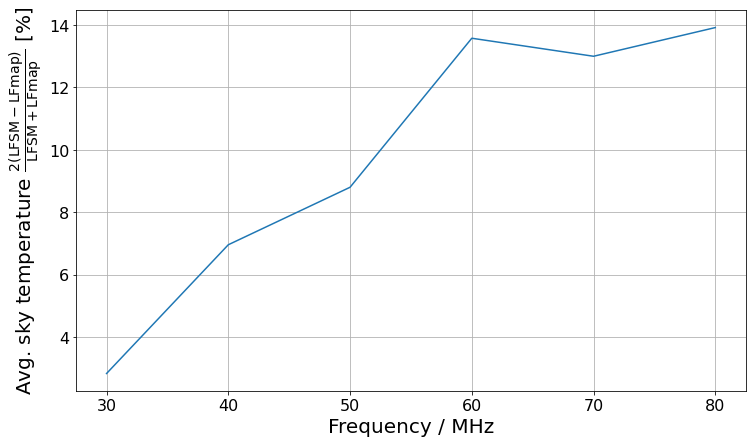

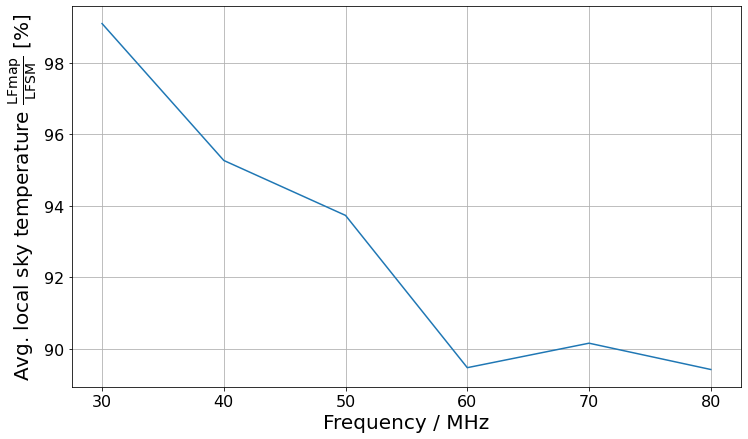

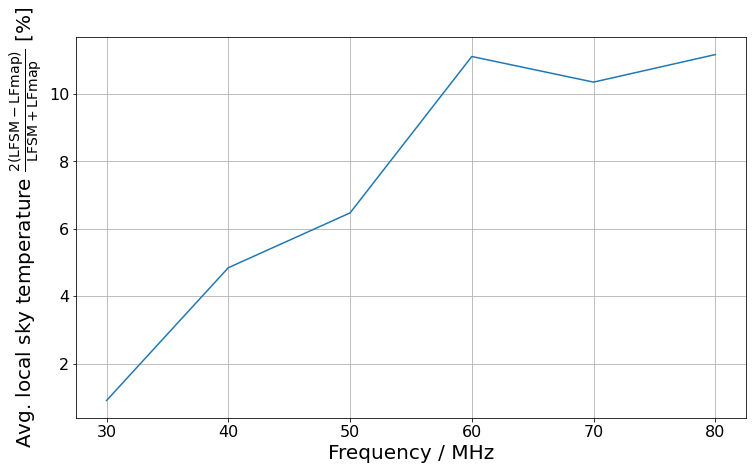

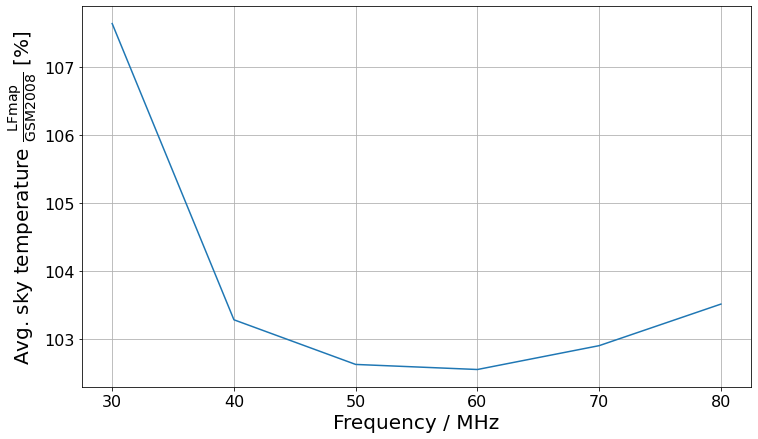

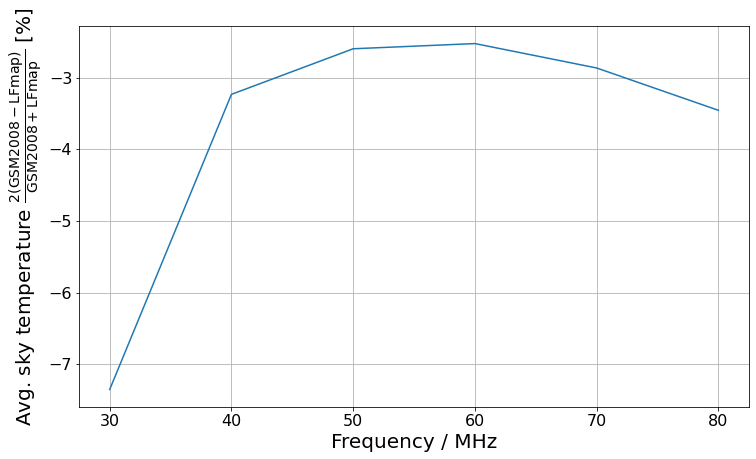

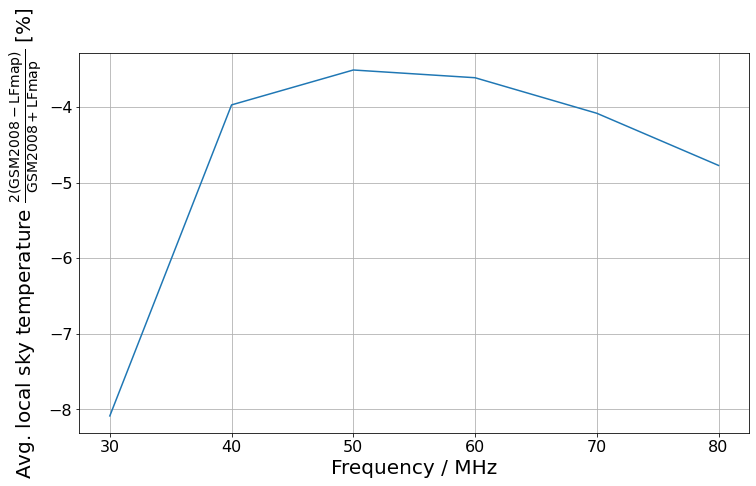

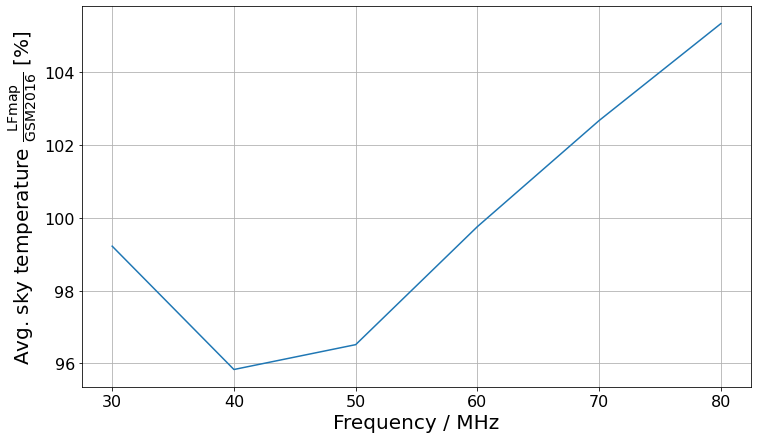

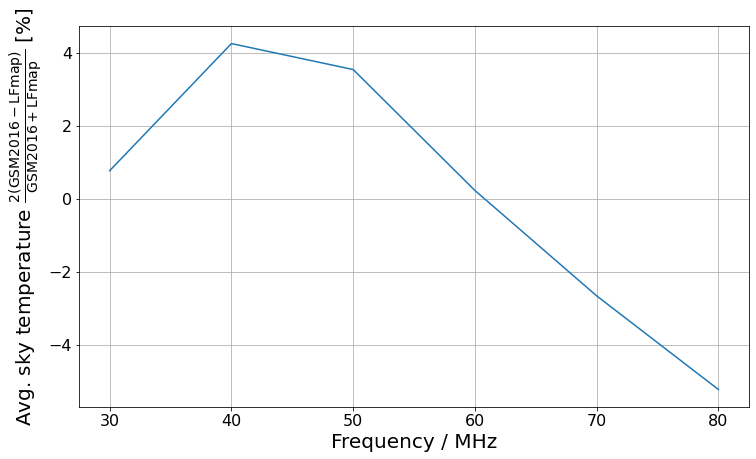

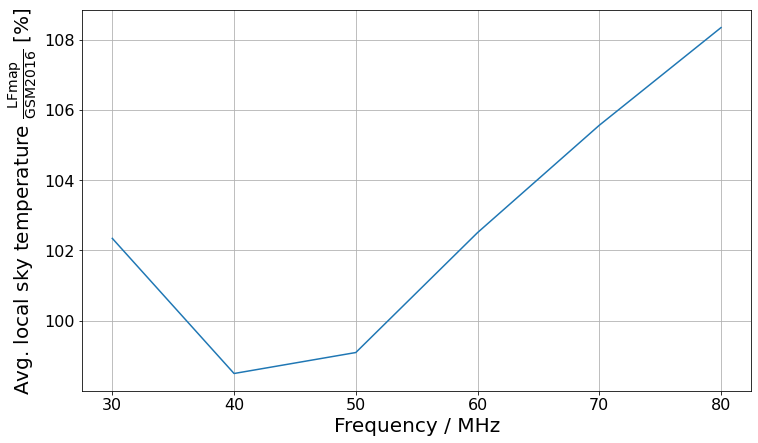

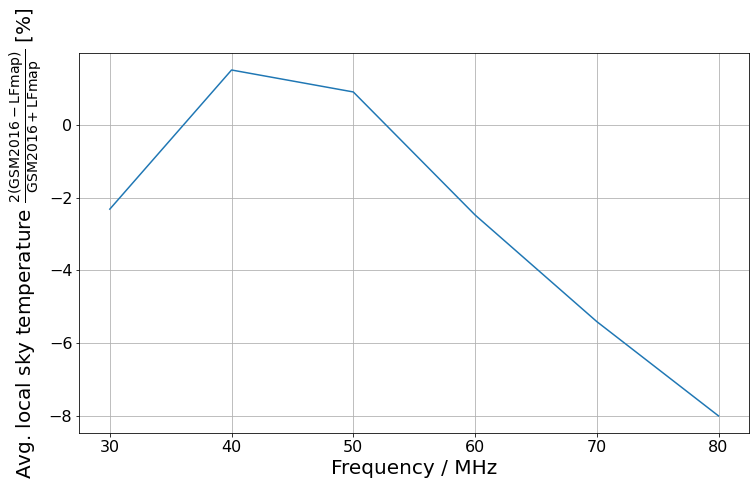

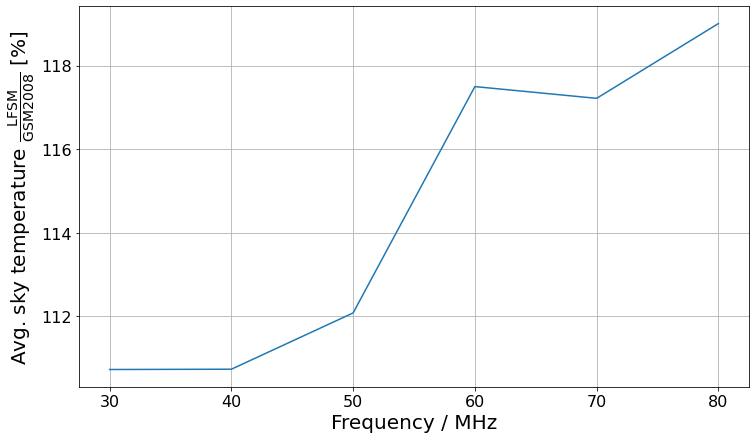

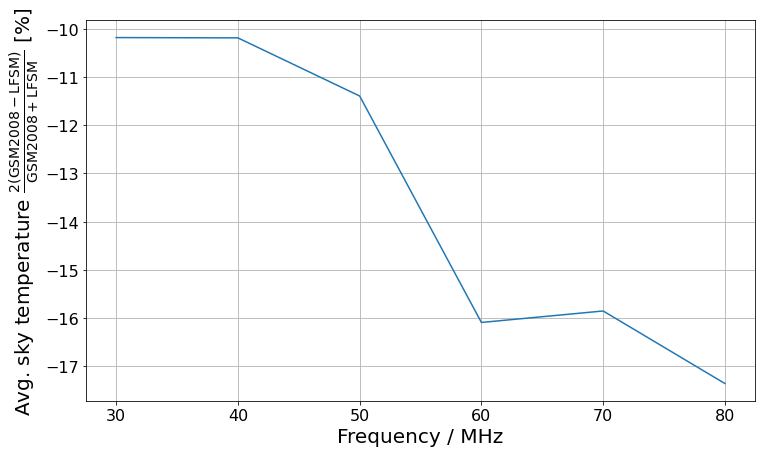

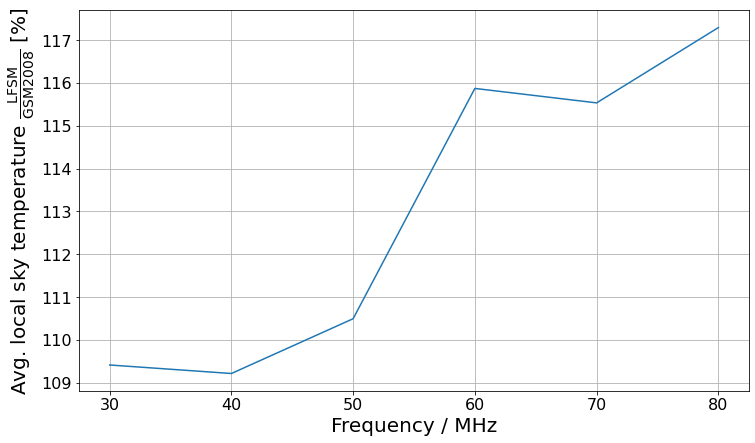

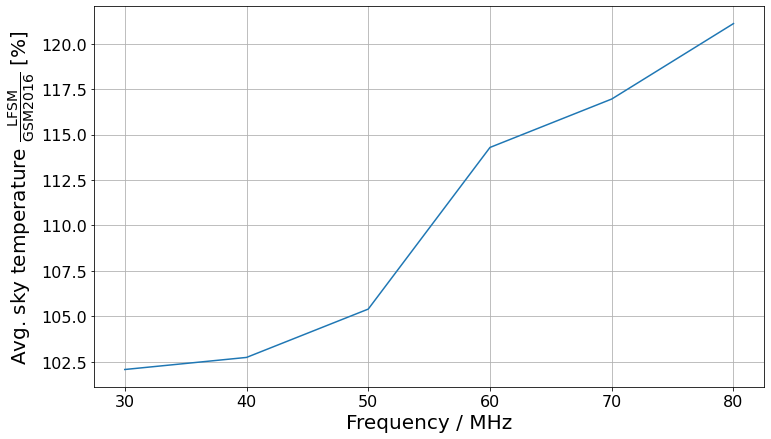

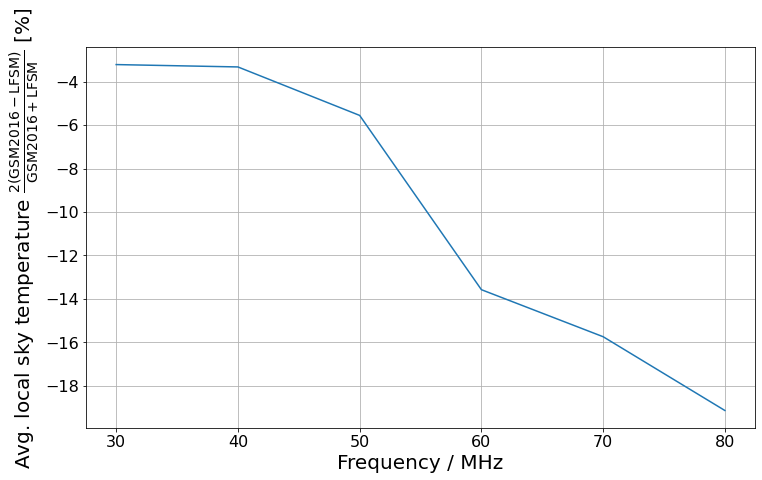

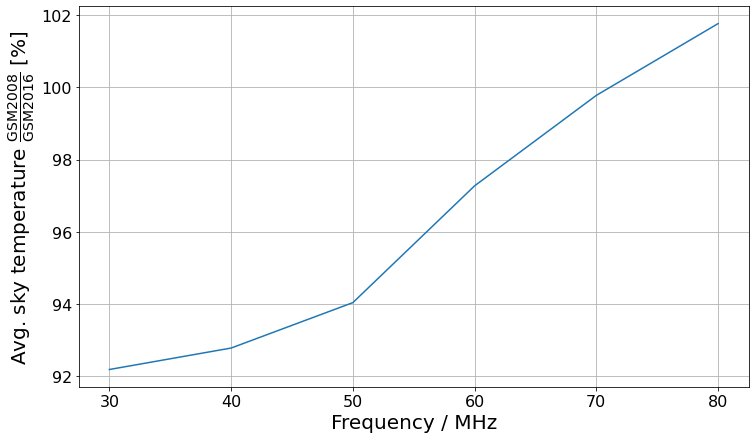

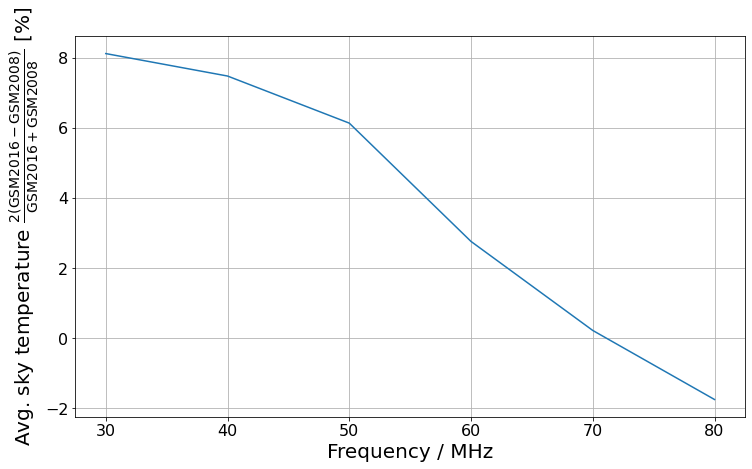

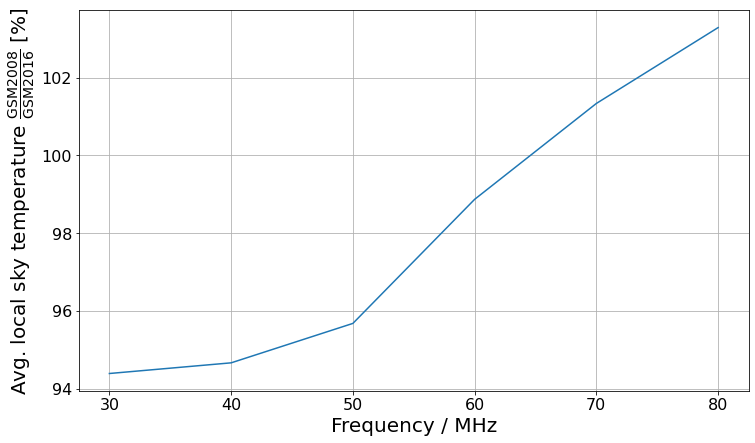

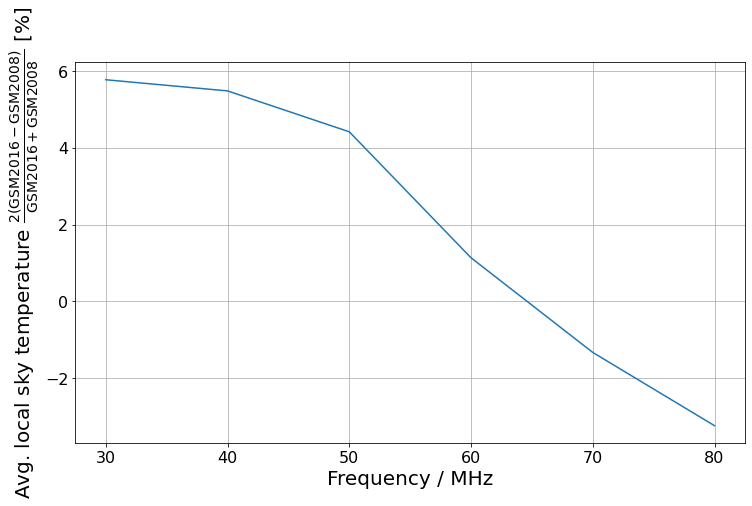

In [238]:
#Plot average sky temperature
plt.figure()
for model_key in model:
    plt.plot(frequency_range,average_T_G[model_key],label=model_title[model_key])
plt.xlabel('Frequency / MHz', fontsize=20)
plt.ylabel('Average sky temperature / K', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.grid(True)
plt.ylim(bottom=0.)
plt.savefig(saveFolder+'AverageSkyTemperature/All_models.png', facecolor='white', bbox_inches='tight')
plt.show()

colors = {"LFmap": "b", "LFSM": "orange", "GSM": "green", "GSM16": "red"}

#Plot average local sky temperature
plt.figure()
for model_key in model:
    plt.plot(frequency_range,average_T_G[model_key],label=model_title[model_key], color=colors[model_key])
    plt.plot(frequency_range,average_T_L[model_key],label=model_title[model_key]+' - local', color=colors[model_key], linestyle='--')
plt.xlabel('Frequency / MHz', fontsize=20)
plt.ylabel('Average sky temperature / K', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.grid(True)
plt.ylim(bottom=0.)
plt.savefig(saveFolder+'AverageSkyTemperature/All_models_local.png', facecolor='white', bbox_inches='tight')
plt.show()

for (m_1,m_2) in it.combinations(model,2):
    #Plot ratio of average sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,100.*average_T_G[m_1]/average_T_G[m_2])
    plt.xlabel('Frequency / MHz', fontsize=20)
    plt.ylabel(r'Avg. sky temperature $\frac{\mathrm{%s}}{\mathrm{%s}}$'%(model_title[m_1],model_title[m_2])+' [%]', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Ratio_model_'+model_title[m_1]+'_'+model_title[m_2]+'.png', facecolor='white', bbox_inches='tight')
    plt.show()

    average_T_G_mean = [np.mean([average_T_G[m_1][i],average_T_G[m_2][i]]) for i in range(len(average_T_G[m_1]))]    
    #Plot difference of average sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,100.*(average_T_G[m_2]-average_T_G[m_1])/average_T_G_mean)
    plt.xlabel('Frequency / MHz', fontsize=20)
    plt.ylabel(r'Avg. sky temperature $\frac{2(\mathrm{%s-%s})}{\mathrm{%s+%s}}$'%(model_title[m_2],model_title[m_1],model_title[m_2],model_title[m_1])+' [%]', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Difference_model_'+model_title[m_1]+'_'+model_title[m_2]+'.png', facecolor='white', bbox_inches='tight')
    plt.show()
    
    #Plot ratio of average local sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,100.*average_T_L[m_1]/average_T_L[m_2])
    plt.xlabel('Frequency / MHz', fontsize=20)
    plt.ylabel(r'Avg. local sky temperature $\frac{\mathrm{%s}}{\mathrm{%s}}$'%(model_title[m_1],model_title[m_2])+' [%]', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Ratio_model_'+model_title[m_1]+'_'+model_title[m_2]+'_local.png', facecolor='white', bbox_inches='tight')
    plt.show()

    average_T_L_mean = [np.mean([average_T_L[m_1][i],average_T_L[m_2][i]]) for i in range(len(average_T_L[m_1]))]    
    #Plot difference of average local sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,100.*(average_T_L[m_2]-average_T_L[m_1])/average_T_L_mean)
    plt.xlabel('Frequency / MHz', fontsize=20)
    plt.ylabel(r'Avg. local sky temperature $\frac{2(\mathrm{%s-%s})}{\mathrm{%s+%s}}$'%(model_title[m_2],model_title[m_1],model_title[m_2],model_title[m_1])+' [%]', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Difference_model_'+model_title[m_1]+'_'+model_title[m_2]+'_local.png', facecolor='white', bbox_inches='tight')
    plt.show()    

# Convolution of the Antenna pattern with the sky temperature

Import some modules.

In [99]:
from scipy import constants
from scipy.integrate import simps

The simple function <i>foldSkyWithAntenna</i> will multiply the squared antenna pattern with the sky temperature. The antenna pattern will be transfomed to healpy convention and further it will be interpolated at the angles of the sky temperature map.

In [100]:
#skyMapDF = skyMapDF_LFSS
def foldSkyWithAntenna(antenna, frequency=None,orientation=None,skyMapDF=None):
    quantity = 'absHeight'
    p = skyMapDF.index.values.astype(float)
    t = skyMapDF.columns.values.astype(float)
    Amp = antenna.get(quantity=quantity, frequency=frequency, newTheta=t, newPhi=p, kind='cubic', changeConvention=True,
                      orientation=orientation)
    foldedAntennaSkyMap = Amp**2*skyMapDF
    return foldedAntennaSkyMap

First we need to generate sky temperature maps at some frequency F.

In [101]:
# first generate maps at some frequeny
map_1 = g_1.generate(frequency)
map_2 = g_2.generate(frequency)

Set the altitude and local sidereal time at the local position where the antenna is (PAO).

In [102]:
# rotate them to Local coordinates at some particular LST time
LSTtime = 18
altitude = -35.206667

Rotated and dump the data.

In [103]:
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,return_only_data=True,xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True,xsize=1439)

Now, convert the data dump to the DataFrame and then use the folding function. We can do this in one step by nesting the functions.

In [104]:
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency, orientation='EW', skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency, orientation='EW', skyMapDF=convert2SkyDF(dump_2,full=False))

In [105]:
orientation='EW'

## Plot of the "antenna-sky temperature" convolution at 18:00 LST
Plot the results of the convolution and compare them by dividing one by the other one.

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/foldedAntennaSkyMap_LFmap_EW_LST_18


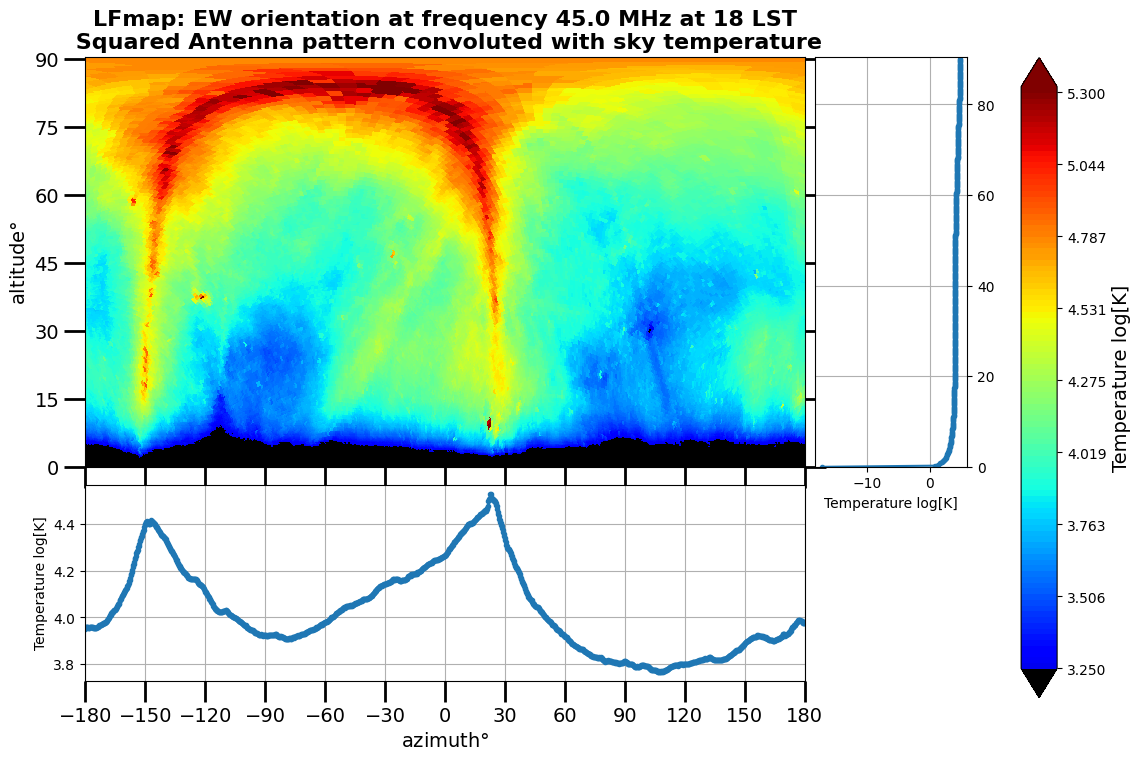

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/foldedAntennaSkyMap_GSM2016_EW_LST_18


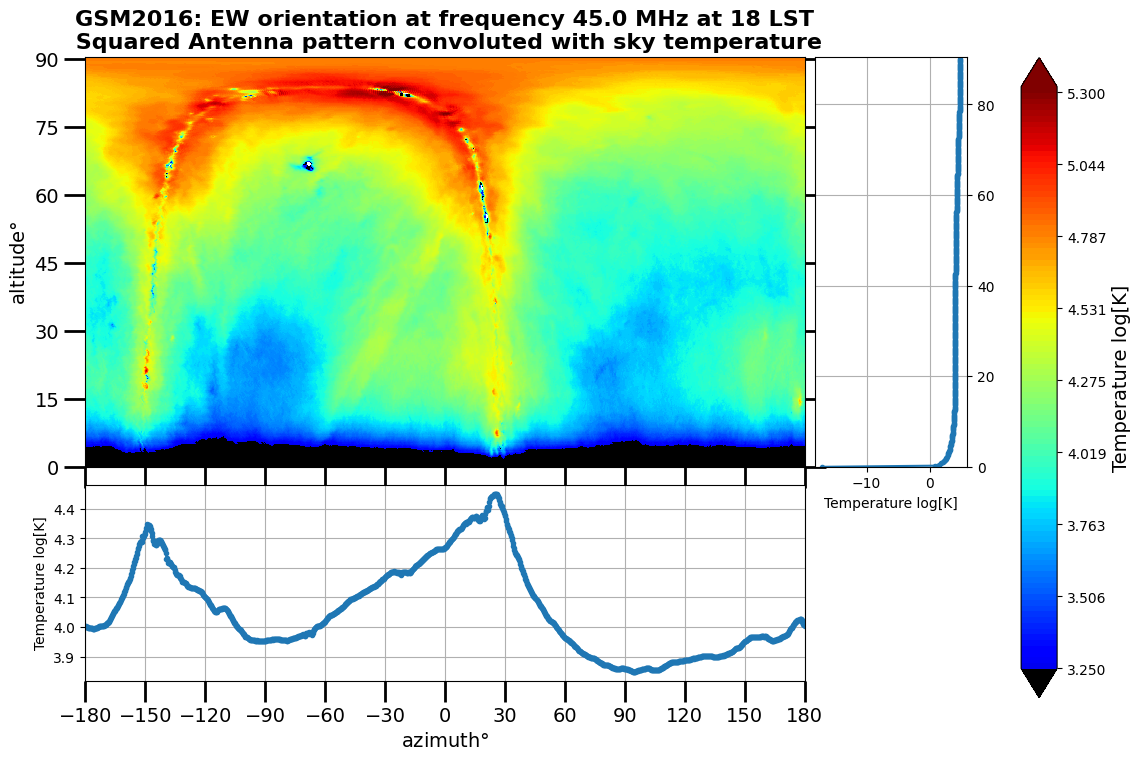

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_foldedAntennaSkyMap_LFmap-foldedAntennaSkyMap_GSM2016_EW_LST_18


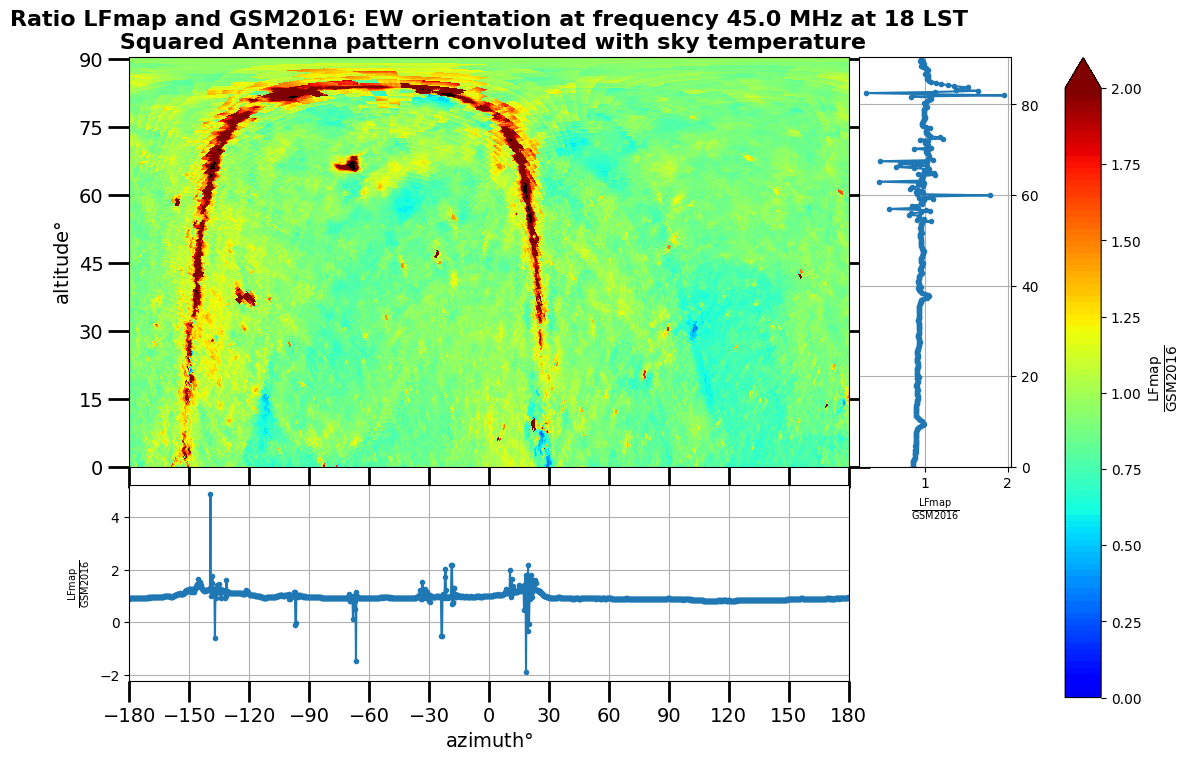

In [106]:
P, T = np.meshgrid(foldedAntennaSkyMap_1.index.values.astype(float), foldedAntennaSkyMap_1.columns.values.astype(float))

save=False
save1= saveFolder+"foldedAntennaSkyMap_"+map_1_title+"_"+orientation+"_LST_"+str(LSTtime)
save2= saveFolder+"foldedAntennaSkyMap_"+map_2_title+"_"+orientation+"_LST_"+str(LSTtime)
save3= saveFolder+"Ratio_foldedAntennaSkyMap_"+map_1_title+"-foldedAntennaSkyMap_"+map_2_title+"_"+ orientation+"_LST_"+str(LSTtime)
                                                                                                    
# log here!
myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30, yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_1_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',Cmin=3.25, Cmax=5.3,
                    save=save1,close=close)

myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30, yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_2_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature'
                    ,Cmin=3.25, Cmax=5.3,
                    save=save2,close=close)

ratio= foldedAntennaSkyMap_1.values.T/foldedAntennaSkyMap_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30, yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle='Ratio '+map_1_title+' and '+map_2_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',
                    Cmin=0,Cmax=2,extend='max', save=save3,close=close)

## "Antenna-sky temperature" convolution at 02:00 LST
Same example as before but done for 2:00 LST.

In [107]:
LSTtime=2

In [108]:
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,return_only_data=True, xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True, xsize=1439)

In [109]:
# first convert the data dump to DF and then use the folding function
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency, orientation='EW',skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency, orientation='EW',skyMapDF=convert2SkyDF(dump_2,full=False))
orientation='EW'

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/foldedAntennaSkyMap_LFmap_EW_LST_2


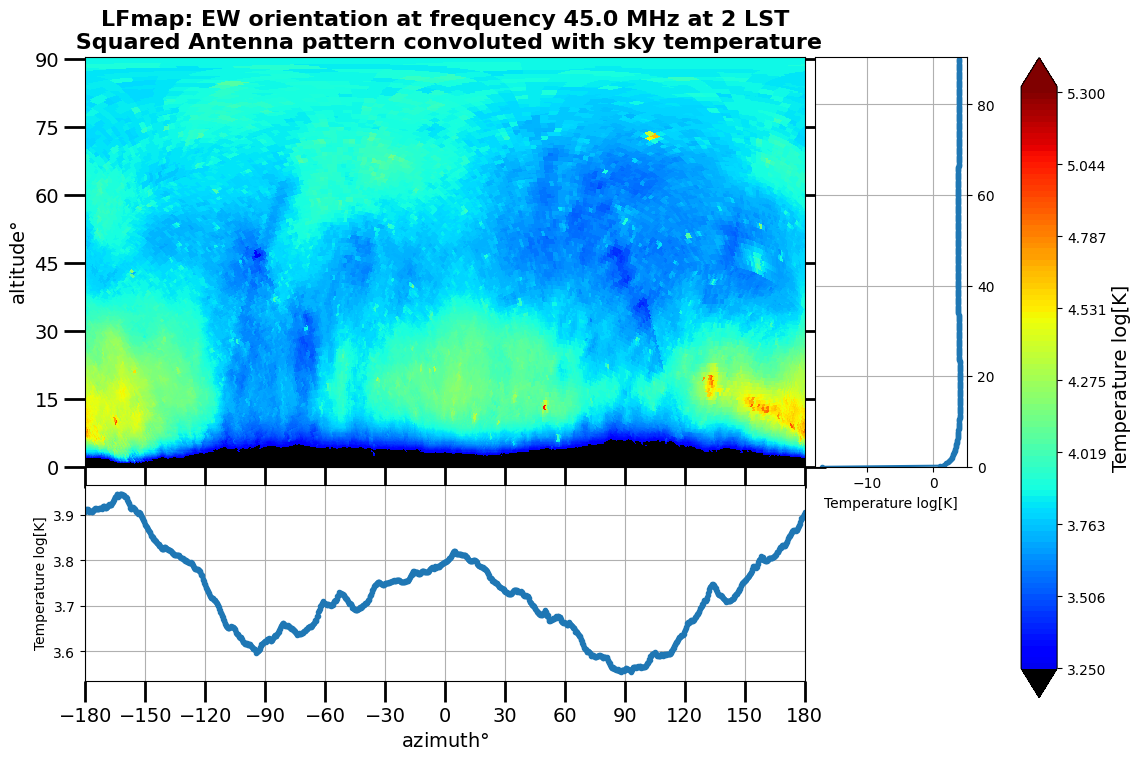

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/foldedAntennaSkyMap_GSM2016_EW_LST_2


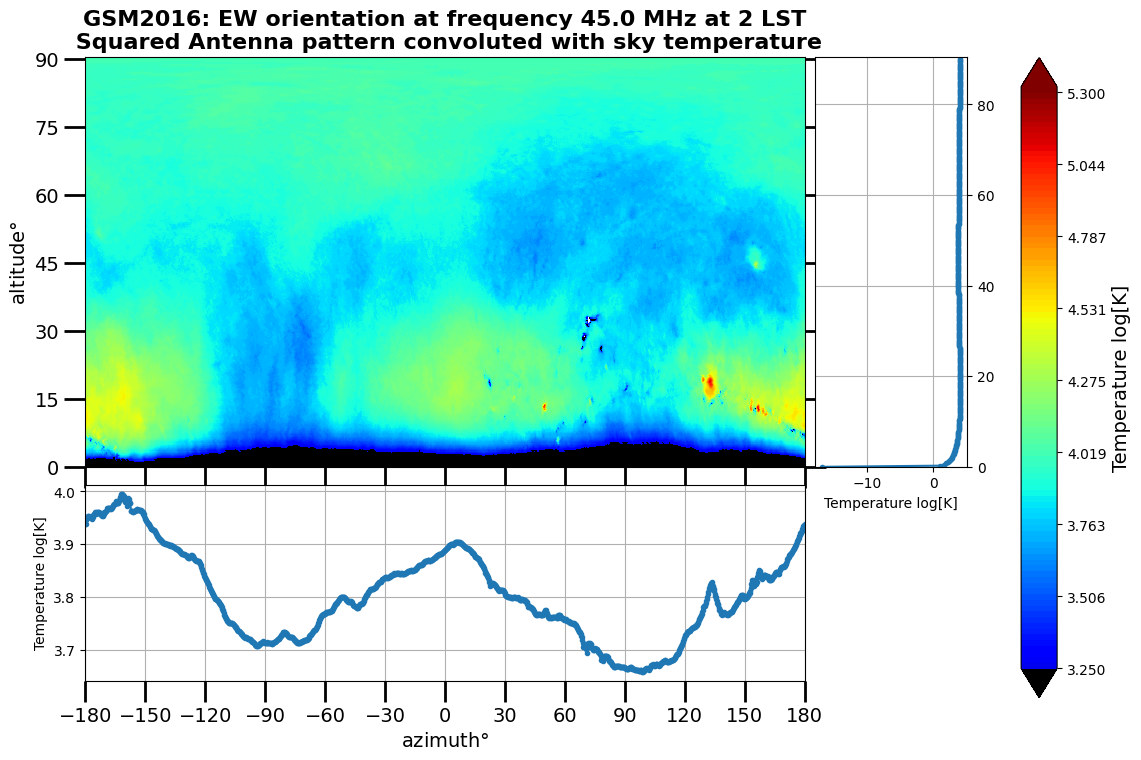

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_foldedAntennaSkyMap_LFmap-foldedAntennaSkyMap_GSM2016_EW_LST_2


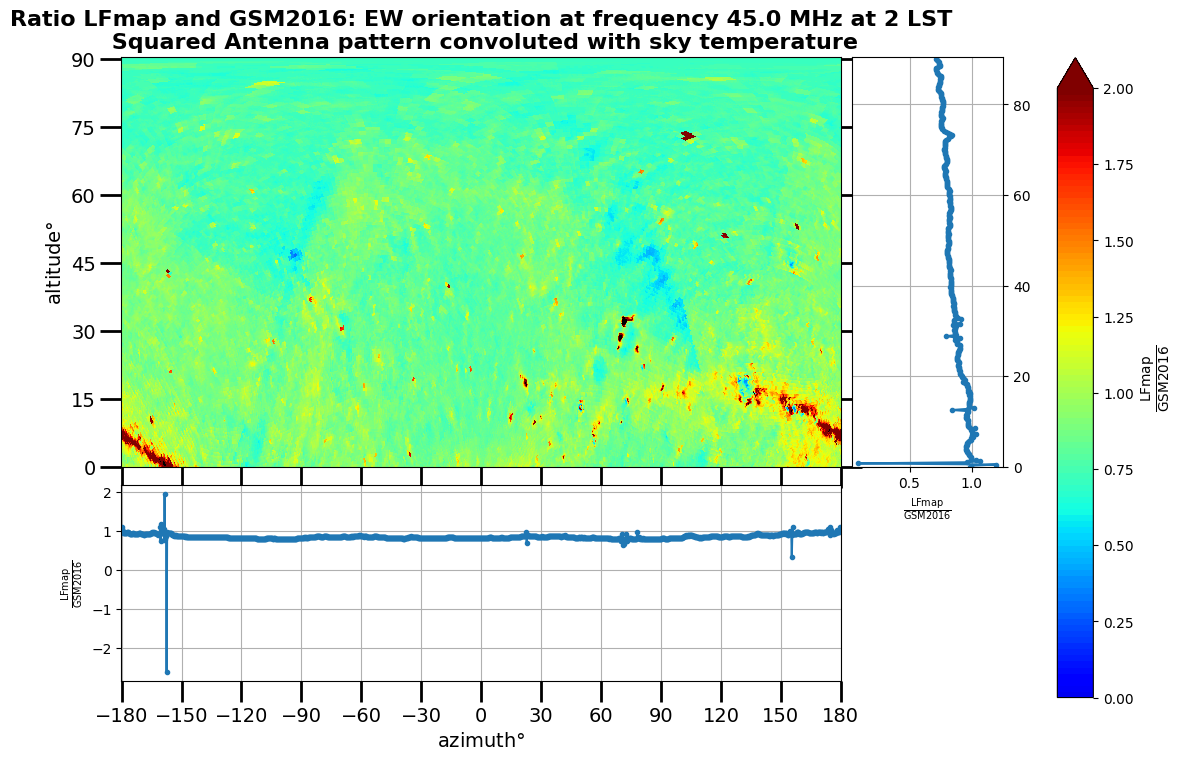

In [110]:
P, T = np.meshgrid(foldedAntennaSkyMap_1.index.values.astype(float),foldedAntennaSkyMap_1.columns.values.astype(float))

save=False
save1= saveFolder+"foldedAntennaSkyMap_"+map_1_title+"_"+orientation+"_LST_"+str(LSTtime)
save2= saveFolder+"foldedAntennaSkyMap_"+map_2_title+"_"+orientation+"_LST_"+str(LSTtime)
save3= saveFolder+"Ratio_foldedAntennaSkyMap_"+map_1_title+"-foldedAntennaSkyMap_"+map_2_title+"_"+ orientation+"_LST_"+str(LSTtime)
                                                                                                    
# log here!
myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle=map_1_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature', Cmin=3.25, Cmax=5.3,
                    save=save1,close=close)

myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30, yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel='Temperature log[K]', extend='both',
                    mainTitle= map_2_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',
                    Cmin=3.25, Cmax=5.3,
                    save=save2,close=close)

ratio=foldedAntennaSkyMap_1.values.T/foldedAntennaSkyMap_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30, yMajorLocator=15, figureWidth=12, figureHeight=8,
                    xlabel='azimuth$\degree$', ylabel='altitude$\degree$', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle='Ratio '+map_1_title+' and '+map_2_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',
                    Cmin=0, Cmax=2, extend='max', save=save3, close=close)

## Integral over the angles
What is of interest for the calibration is the integral over the angles: <br>
$\int_{\Omega} T_{sky}(t,f,\theta,\phi) |H(f,\theta,\phi)|^{2} d\Omega$

Define a function for the integration <i>integrateOverAngles</i>

In [111]:
# integrate the folded sky map over the angles
def integrateOverAngles(foldedAntennaSkyMap):
    p = np.deg2rad(foldedAntennaSkyMap.index.values.astype(float))
    t = np.deg2rad(foldedAntennaSkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    angePrefactor=np.sin(T[:,::-1])
    integratedOverAngles=simps(simps(foldedAntennaSkyMap*angePrefactor,t),p)
    return integratedOverAngles

As was showed before, first generate the rotated maps, dump the result, convert to the DataFrame and finally fold the antenna with the sky temperature maps.

In [112]:
LSTtime=18
rotAngles = [(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1, rot=rotAngles, coord=c_coord_1, return_only_data=True, xsize=1439)
dump_2 = newvisufunc.projview(map_2, rot=rotAngles, coord=c_coord_2, return_only_data=True, xsize=1439)
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency, orientation='EW', skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency, orientation='EW', skyMapDF=convert2SkyDF(dump_2,full=False))

Once we have the convoluted maps we can integrate them.

In [113]:
angle_integrated_1 = integrateOverAngles(foldedAntennaSkyMap_1)
angle_integrated_2 = integrateOverAngles(foldedAntennaSkyMap_2)

Print the values and their ratio.

In [114]:
print(angle_integrated_1)
print(angle_integrated_2)
print('Ratio: ',angle_integrated_1/angle_integrated_2)

88085.58290535898
86763.86434716117
Ratio:  1.015233514184077


Try this for different LST, for example 2:00

In [115]:
LSTtime=2
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1, return_only_data=True,xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True,xsize=1439)
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=45, orientation='EW', skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=45, orientation='EW', skyMapDF=convert2SkyDF(dump_2,full=False))

In [116]:
angle_integrated_1 = integrateOverAngles(foldedAntennaSkyMap_1)
angle_integrated_2 = integrateOverAngles(foldedAntennaSkyMap_2)
print(angle_integrated_1)
print(angle_integrated_2)
print('Ratio: ',angle_integrated_1/angle_integrated_2)

47564.56273851213
53047.25066942385
Ratio:  0.896645200991125


# Power and Power spectral density calculation
Once we have the integrated antenna-sky temperature term it is easy to calculate the power spectral density. 

The power spectrum density is therefore: <br>

 \begin{equation*} 
\mathscr{P}_{sky}(t,f) = \frac{k_{b}}{c^{2}} f^{2} \int_{\Omega} T_{sky}(t,f,\theta,\phi) \frac{|H(f,\theta,\phi)|^{2}Z_{0}}{R_{r}} d\Omega           \end{equation*} <br>

where <br>
 \begin{equation*}
 <|H(f,\theta,\phi)|^{2}> = \frac{1}{2}(|J_{\theta}|^2+|J_{\phi}|^2|)
\end{equation*} <br>

The term <br>

 \begin{equation*}
\int_{\Omega} T_{sky}(t,f,\theta,\phi) |H(f,\theta,\phi)|^{2}  d \Omega
\end{equation*} <br>

is the integral of antenna-sky temperature that was calculated before.

To get the Power we need to just integrate the power spectrum density over the frequency. <br>

 \begin{equation*}
P_{sky}(t,f) = \int_{f} \mathscr{P}_{sky}(t,f) df
\end{equation*} <br>

Thus, the full equation for the Sky Power Radio Emmision is: <br>

 \begin{equation*}
 P_{sky}(t,f) = \frac{k_{b}}{c^{2}} \int_{f} f^{2} \int_{\Omega} T_{sky}(t,f,\theta,\phi) \frac{|H(f,\theta,\phi)|^{2}Z_{0}}{R_{r}} df d\Omega  
\end{equation*} <br>

where $Z_0$ is the vacuum impedance, $R_r$ is the antenna impedance, $k_b$ the Boltzmann constant and $c$ is the speed of light.

***

<p style='text-align: justify;'>
In the following cell are all necessery functions for the power calculation. Each of them was presented and described previously. The only new function is <i>simulateGalacticModulationCurve</i> that is calculating the power spectrum density for the chose frequency and LST. By default a DataFrame for frequencies from 30 to 80 MHz over the whole sidereal day is generated. The default frequency and LST step is 1.
</p>

In [117]:
# this function helps to convert the data dump from newvisufunc.projview() to DF
def convert2SkyDF(data_dump,full=False):
    def DFtemplateCreator(xs,ys,yName=None):
        colList = [str(x) for x in xs]
        nan_init = np.empty((len(xs),len(ys),))
        nan_init[:]=np.nan
        templateDF = pd.DataFrame(nan_init.T, columns = colList)
        templateDF.insert(0,yName,ys)
        templateDF = templateDF.set_index(yName)
        return templateDF
    longitude,latitude,grid_map = data_dump
    latitudeDeg = np.rad2deg(latitude)
    longitudeDeg = np.rad2deg(longitude)
    skyMapDF = DFtemplateCreator(latitudeDeg,longitudeDeg,yName=None)
    skyMapDF.iloc[:,:] = grid_map.T
    if full is False:
        skyMapDF = skyMapDF.iloc[:,np.where(skyMapDF.columns.astype(float) >=0)[0].tolist()]
    skyMapDF=skyMapDF.sort_index()
    return skyMapDF

def DFtemplateCreator(xs,ys,yName=None):
    colList = [str(x) for x in xs]
    nan_init = np.empty((len(xs),len(ys),))
    nan_init[:]=np.nan
    templateDF = pd.DataFrame(nan_init.T, columns = colList)
    templateDF.insert(0,yName,ys)
    templateDF = templateDF.set_index(yName)
    return templateDF

def simulateGalacticModulationCurve(antennaClass=None, skyMapClass=None, startFrequency=30.0,endFrequency=80.0,frequencySpacing=2.0,
                                    startLST=0,endLST=24,LSTspacing=2, coord=['C'],
                                    orientation=None,returnOnlyIntegratedAngle=False, impedanceFile=None):
    Z0 = constants.physical_constants["characteristic impedance of vacuum"][0]
    frequencies = np.arange(startFrequency,endFrequency+frequencySpacing,frequencySpacing)
    LSTtimes = np.arange(startLST,endLST,LSTspacing)
    if impedanceFile is not None:
        impedanceData = np.loadtxt(impedanceFile)
        impedanceFunction = interp1d(impedanceData[0],impedanceData[1])
    else:
        print('No impedance file! Impedance set to 1')
    if antennaClass == None:
        print('Pass the antenna class please.')
        return None
    if skyMapClass == None:
        print('Pass the sky map class please.')
        return None
    if orientation == None:
        print('Orientation? EW or NS?')
        return None
    altitude = -35.206667
    inc = 0.1
    angle_integratedList=[]
    powerSpectrumDensityList=[]
    constantFactor = (2*constants.k/constants.c**2)*Z0
    for LSTtime in tqdm(LSTtimes):
        angle_integratedList_at_freq_F=[]
        powerSpectrumDensityList_at_freq_F=[]
        for frequency in frequencies:
            if impedanceFile is not None:
                freqDepPrefactor = ((frequency*1e+6)**2)/impedanceFunction(frequency)
            else:
                freqDepPrefactor = (frequency*1e+6)**2
            #print('I AM AT FREQUENCY: '+str(frequency)+' Mhz.')
            skyMap = skyMapClass.generate(frequency)
            rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
            # xsize=1439 will give angle spacing of 0.25 degrees
            dump = newvisufunc.projview(skyMap,rot=rotAngles, coord=coord, return_only_data=True,xsize=1439)
            foldedAntennaSkyMap = foldSkyWithAntenna(antennaClass, frequency=frequency, orientation=orientation, skyMapDF=convert2SkyDF(dump, full=False))
            angle_integrated = integrateOverAngles(foldedAntennaSkyMap)
            angle_integratedList_at_freq_F.append(angle_integrated)
            # power spectrum density
            powerSpectrumDensity = constantFactor*freqDepPrefactor*angle_integrated
            powerSpectrumDensityList_at_freq_F.append(powerSpectrumDensity)
        angle_integratedList.append(np.asarray(angle_integratedList_at_freq_F))
        powerSpectrumDensityList.append(np.asarray(powerSpectrumDensityList_at_freq_F))
    if returnOnlyIntegratedAngle == True:
        angle_integratedDF = DFtemplateCreator(frequencies,LSTtimes,yName=None)
        angle_integratedDF.iloc[:,:] = np.asarray(angle_integratedList)
        return angle_integratedDF
    else:
        powerSpectrumDensityDF = DFtemplateCreator(frequencies,LSTtimes,yName=None)
        powerSpectrumDensityDF.iloc[:,:]= np.asarray(powerSpectrumDensityList)
        return powerSpectrumDensityDF

#skyMapDF = skyMapDF_LFSS
def foldSkyWithAntenna(antenna, frequency=None,orientation=None,skyMapDF=None):
    quantity = 'absHeight'
    p = skyMapDF.index.values.astype(float)
    t = skyMapDF.columns.values.astype(float)
    Amp = antenna.get(quantity=quantity, frequency=frequency, newTheta=t, newPhi=p, kind='linear', changeConvention=True,
                      orientation=orientation)
    foldedAntennaSkyMap = Amp**2*skyMapDF
    return foldedAntennaSkyMap

# integrate the folded sky map over the angles
def integrateOverAngles(foldedAntennaSkyMap):
    p = np.deg2rad(foldedAntennaSkyMap.index.values.astype(float))
    t = np.deg2rad(foldedAntennaSkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    angePrefactor=np.sin(T[:,::-1])
    integratedOverAngles=simps(simps(foldedAntennaSkyMap*angePrefactor,t),p)
    return integratedOverAngles

<p style='text-align: justify;'>
Ideally you should simulate as small time deltas as possible and than binned them approprietly.
For example, if the measured data are binned to 1 hour bins, calculating the simulated data at one hour steps might give you a 30 minutes time offset. Better is to simulate 15 minutes steps and binned them to 1 hour. This is more representative then. <br>
If the measured data set is binned to 15 minute bins, a simulated DataFrame with 15 minutes bins should be OK since the possible offset is only 7.5 minutes.
</p>

If the time binning is required, function <i>DFtimeBinning</i> can be used.

In [118]:
# time binning
def DFtimeBinning(DF,timeBinWidth=1):
    new=[]
    newTimes=[]
    rowNumer, _ = DF.shape
    tstart=float(DF.index.values[0])
    tstep=float(DF.index.values[1])-float(DF.index.values[0])
    tWidth = int(timeBinWidth/tstep + 1) # how many cols have to be integrated to have the wanted frequency binning, the +1 is because the last  element is excluded
    totalNumberOfNewTimeRows=int((rowNumer-1)/(tWidth-1))
    for i in range(0,totalNumberOfNewTimeRows,1):
        newTimes.append(i*timeBinWidth)
        new.append(DF.iloc[i:i+tWidth,:].mean(axis=0))
    new = np.asarray(new)
    newTimes=np.asarray(newTimes)
    newDF = DFtemplateCreator(DF.columns.values, newTimes)
    newDF.iloc[:,:] = np.asarray(new)
    return newDF

***

## Power spectrum density

Assign the save folder for the results.

In [119]:
saveFolder='./results/skySimulation/'

Further:<br>
- Set the path to the impedance files
- create antenna pattern classes for EW and NS orientation
- create sky temperature maps

In [120]:
impedanceFile_EW = offlinePath+"share/auger-offline/doc/ExampleApplications/RDGalacticCalibrationTools/EW_impedance_RD.txt"
impedanceFile_NS = offlinePath+"share/auger-offline/doc/ExampleApplications/RDGalacticCalibrationTools/NS_impedance_RD.txt"

# antenna patter class
antennaEW = getAntennaPatternQuantities(antennaPathEW)
antennaNS = getAntennaPatternQuantities(antennaPathNS)
# for Polisensky's LFmap, these are by default generated in Celestial coordinated
#g_LFmap = LFmap(LFmapPath+"/healpyFits/")
# for lf map from pygdsem
#g_LFSS = LowFrequencySkyModel(freq_unit='MHz')

#use g_1 and g_2 instead

### Calculate the power spectrum density for the EW orientation with the maps from the 1st model.

In [121]:
# model 1 EW
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_1_EW = simulateGalacticModulationCurve(antennaClass = antennaEW, skyMapClass = g_1, startFrequency = startFrequency,
                                                        endFrequency = endFrequency, frequencySpacing=frequencySpacing, coord=c_coord_1, 
                                                        orientation ='EW', returnOnlyIntegratedAngle=False,
                                                        startLST = startLST, endLST=endLST, LSTspacing=LSTspacing, impedanceFile=impedanceFile_EW)

In [122]:
# for saving
powerSpectrumDensityDF_1_EW.to_csv(saveFolder+'powerSpectrumDensityDF_'+map_1_title+'_EW.csv')

In [123]:
# for reading
powerSpectrumDensityDF_1_EW = pd.read_csv(saveFolder+'powerSpectrumDensityDF_'+map_1_title+'_EW.csv',index_col=0)

### Calculate the power spectrum density for the NS orientation with the maps from the 1st model.

In [124]:
# model 1 NS
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_1_NS = simulateGalacticModulationCurve(antennaClass=antennaNS, skyMapClass=g_1, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, coord=c_coord_1, 
                                                        orientation='NS', returnOnlyIntegratedAngle=False,
                                                        startLST=startLST, endLST=endLST, LSTspacing=LSTspacing, impedanceFile=impedanceFile_NS)

In [125]:
# for saving
powerSpectrumDensityDF_1_NS.to_csv(saveFolder+'powerSpectrumDensityDF_'+map_1_title+'_NS.csv')

In [126]:
# for reading
powerSpectrumDensityDF_1_NS = pd.read_csv(saveFolder+'powerSpectrumDensityDF_'+map_1_title+'_NS.csv',index_col=0)

### Calculate the power spectrum density for the EW orientation with the maps from the 2nd model.

In [127]:
# map 2 EW
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_2_EW = simulateGalacticModulationCurve(antennaClass=antennaEW, skyMapClass=g_2, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, coord = c_coord_2, 
                                                        orientation='EW', returnOnlyIntegratedAngle=False,
                                                        startLST=startLST, endLST=endLST, LSTspacing=LSTspacing, impedanceFile=impedanceFile_EW)

In [128]:
# for saving
powerSpectrumDensityDF_2_EW.to_csv(saveFolder+'powerSpectrumDensityDF_'+map_2_title+'_EW.csv')

In [129]:
# for reading
powerSpectrumDensityDF_LFmap_EW = pd.read_csv(saveFolder+'powerSpectrumDensityDF_'+map_2_title+'_EW.csv',index_col=0)

### Calculate the power spectrum density for the NS orientation with the maps from the 2nd model.

In [130]:
# map 2 NS
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_2_NS = simulateGalacticModulationCurve(antennaClass=antennaNS, skyMapClass=g_2, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, coord=c_coord_2, 
                                                        orientation='NS', returnOnlyIntegratedAngle=False,
                                                        startLST=startLST, endLST=endLST, LSTspacing=LSTspacing, impedanceFile=impedanceFile_NS)

In [131]:
# for saving
powerSpectrumDensityDF_2_NS.to_csv(saveFolder+'powerSpectrumDensityDF_'+map_2_title+'_NS.csv')

In [132]:
# for reading
powerSpectrumDensityDF_LFmap_NS = pd.read_csv(saveFolder+'powerSpectrumDensityDF_'+map_2_title+'_NS.csv',index_col=0)

### Plots - Power spectrum density in EW orientation

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerSpectrumDensityDF_LFmap_EW


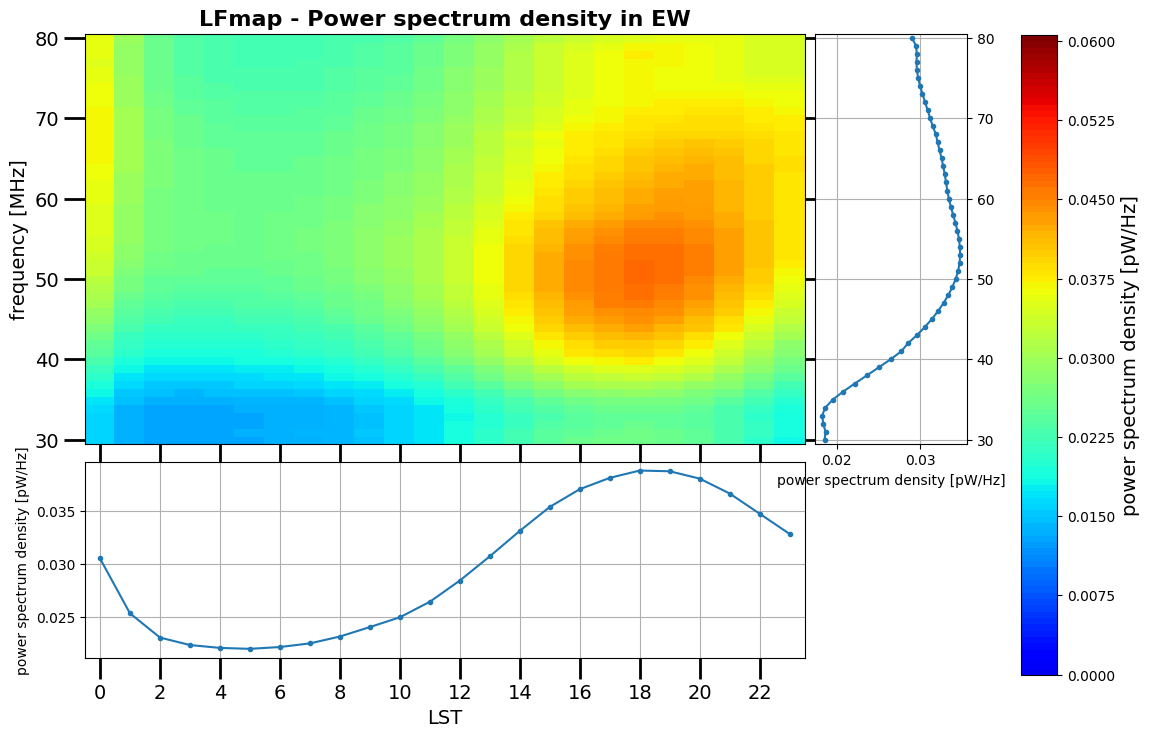

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerSpectrumDensityDF_GSM2016_EW


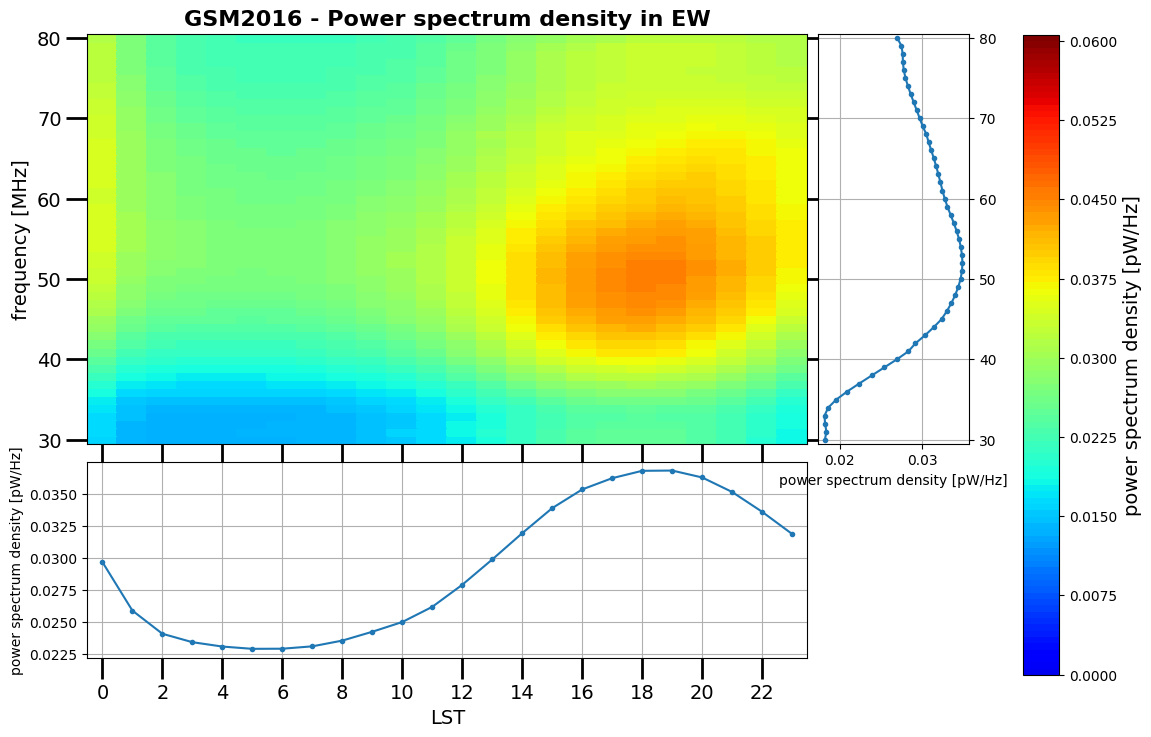

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_PowerSpectrumDensity_EW


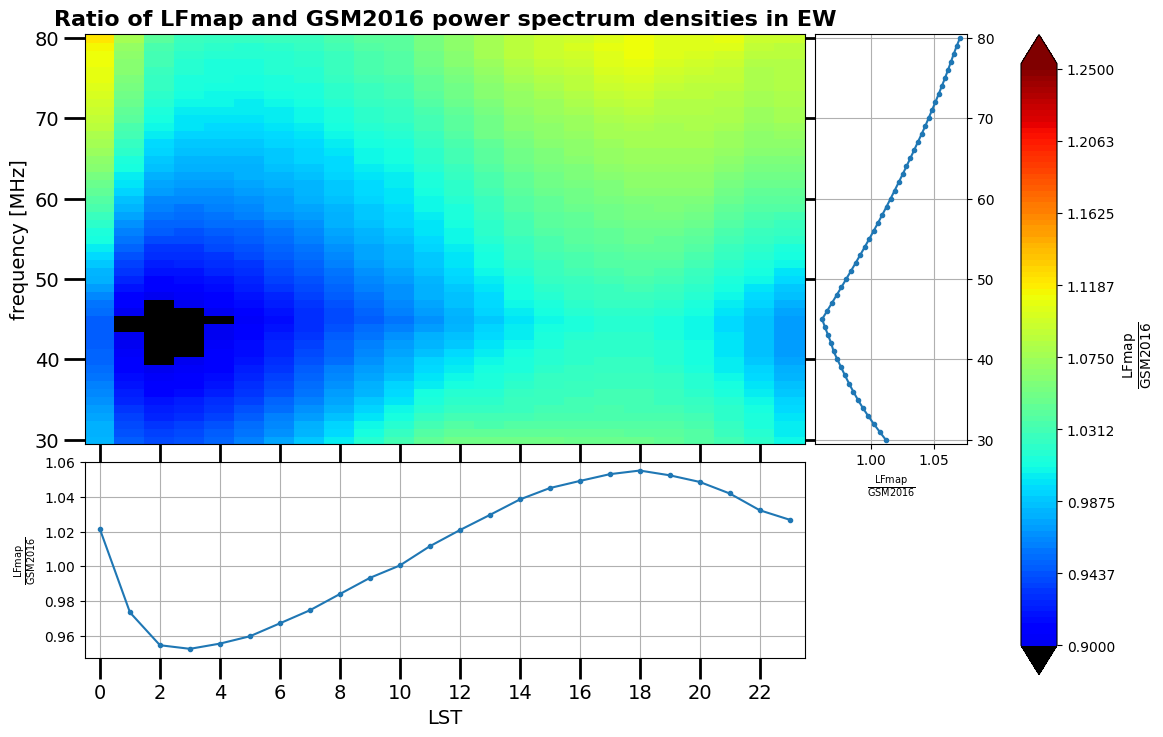

In [133]:
orientation = 'EW'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerSpectrumDensityDF_'+map_1_title+'_'+orientation
save2 = saveFolder+'powerSpectrumDensityDF_'+map_2_title+'_'+orientation
save3 = saveFolder+'Ratio_PowerSpectrumDensity_'+orientation

LST_grid, freq_grid = np.meshgrid(powerSpectrumDensityDF_1_EW.index.values.astype(float), powerSpectrumDensityDF_2_EW.columns.values.astype(float))

myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_1_EW.values.T*1e+18, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle=map_1_title+" - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save1,close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_2_EW.values.T*1e+18, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle=map_2_title+" - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save2,close=close)

ratio = powerSpectrumDensityDF_1_EW.values/powerSpectrumDensityDF_2_EW.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T,slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title), xMajorLocator=2, yMajorLocator=10,
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25,ymin=29.5,ymax=80.5, 
                    extend='both',
                    save=save3, close=close)

***
***


### Plots - Power spectrum density in NS orientation

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerSpectrumDensityDF_LFmap_NS


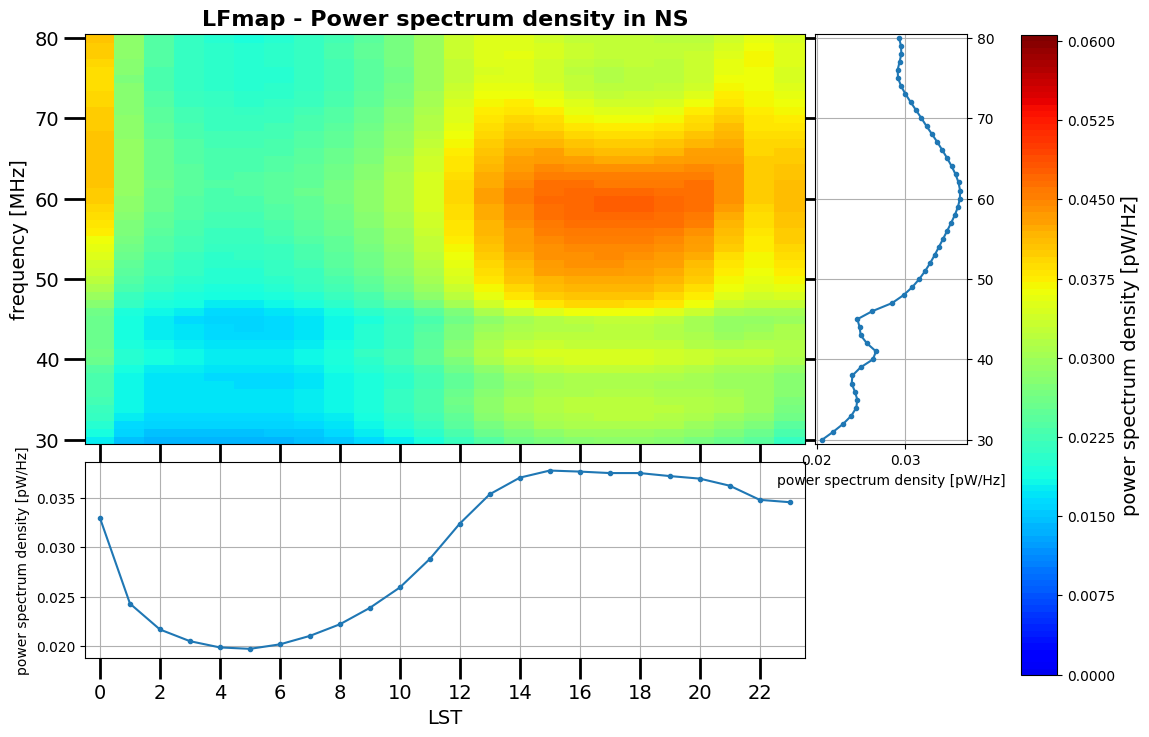

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerSpectrumDensityDF_GSM2016_NS


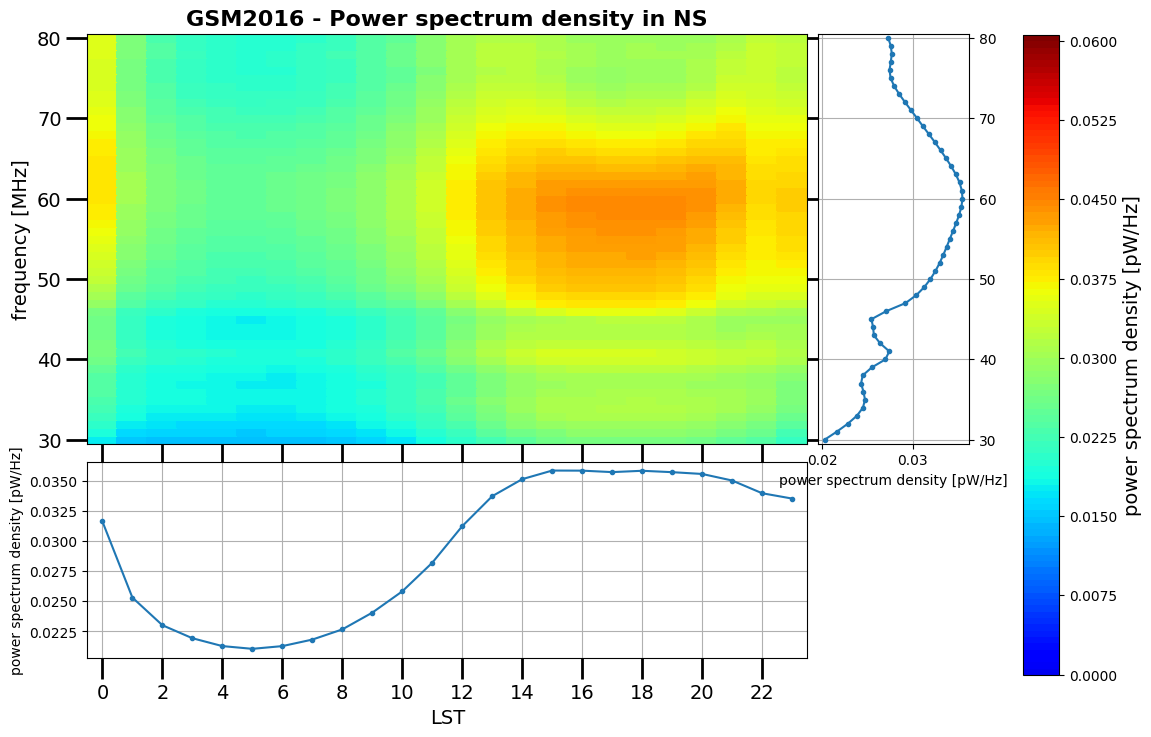

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_PowerSpectrumDensity_NS


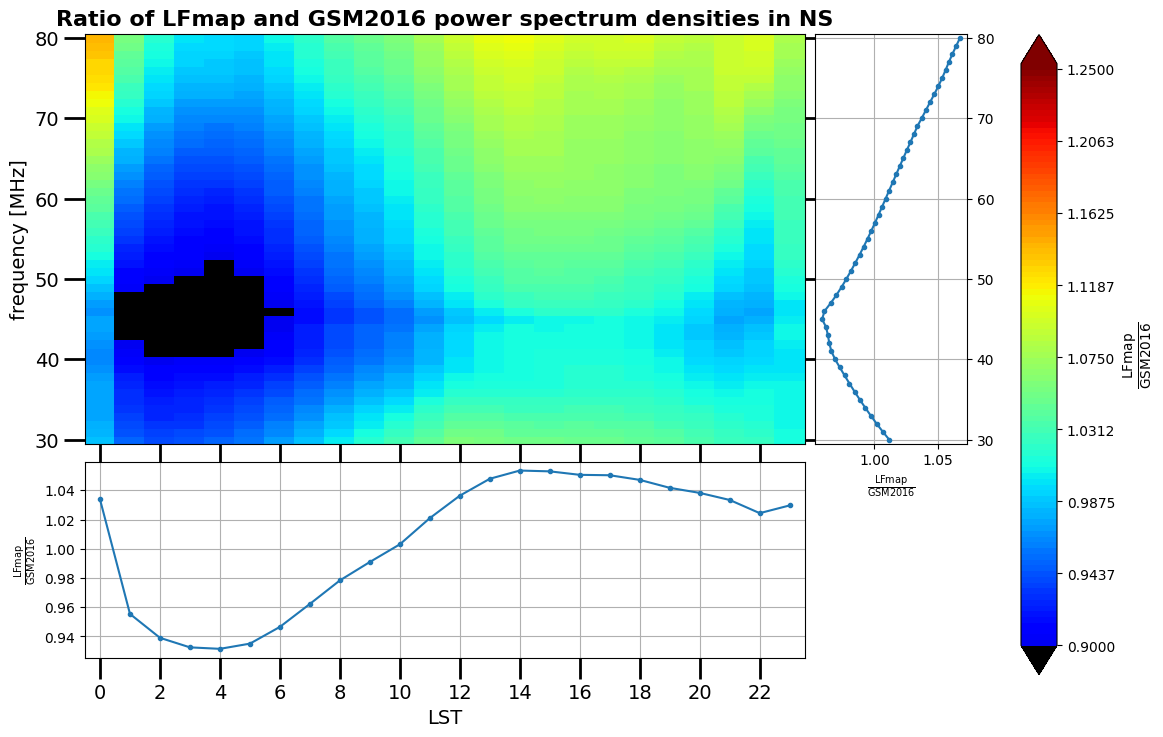

In [134]:
orientation = 'NS'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerSpectrumDensityDF_'+map_1_title+'_NS'
save2 = saveFolder+'powerSpectrumDensityDF_'+map_2_title+'_NS'
save3 = saveFolder+'Ratio_PowerSpectrumDensity_NS'

LST_grid, freq_grid = np.meshgrid(powerSpectrumDensityDF_1_NS.index.values.astype(float), powerSpectrumDensityDF_1_NS.columns.values.astype(float))
myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_1_NS.values.T*1e+18, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle=map_1_title+" - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save1, close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_2_NS.values.T*1e+18, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]', cbarLabel='power spectrum density [pW/Hz]', xMajorLocator=2, yMajorLocator=10,
                    mainTitle=map_2_title+" - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06, ymin=29.5, ymax=80.5,
                    save=save2, close=close)

ratio = powerSpectrumDensityDF_1_NS.values/powerSpectrumDensityDF_2_NS.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T,slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST', ylabel='frequency [MHz]', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title), xMajorLocator=2, yMajorLocator=10,
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25, ymin=29.5, ymax=80.5,
                    extend='both',
                    save=save3,close=close)

## Power
To get the power we need just to integrate the power spectrum density over the frequencies. <br>

 \begin{equation*}
P_{sky}(t,f) = \int_{f} \mathscr{P}_{sky}(t,f) df
\end{equation*} <br>

<p style='text-align: justify;'>
For Power in 1 Mhz bins a power spectrum density with at least 1 MHz spacing is needed. Ideally one should generate power spectrum density in the same frequencies as is the frequency delta of the measured data. For example, sampling frequency 250 MHz will produced spectrum with frequency delta 0.12 MHz, therefore 0.12 Mhz should be the step in the power spectrum density. However, the power spectrum density is not varying dramatically in 1 MHz steps, so 1 Mhz steps in power spectrum density should be fine.
</p>

Function <i>integratePowerSpectrumDensityDF2PowerSpectrum</i> will do the frequency integration.

In [135]:
def integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF, fbinWidth=1):
    powerSpectrum=[]
    newFrequencies=[]
    _, colNumber = powerSpectrumDensityDF.shape
    fstart=float(powerSpectrumDensityDF.columns.values[0])
    fstep=float(powerSpectrumDensityDF.columns.values[1])-float(powerSpectrumDensityDF.columns.values[0])
    fwidth = int(fbinWidth/fstep + 1) # how many cols have to be integrated to have the wanted frequency binning, the +1 is because the last  element is excluded
    totalNumberOfNewFreqColumns=int((colNumber-1)/(fwidth-1))
    for i in range(0,totalNumberOfNewFreqColumns,1):
        newFrequencies.append(fstart+i*fbinWidth)
        #print(powerSpectrumDensityDF_LFSS.iloc[i:i+fwidth,:].index.values)
        powerSpectrum.append(simps(powerSpectrumDensityDF.iloc[:,i:i+fwidth].values, 
                                   powerSpectrumDensityDF.iloc[:,i:i+fwidth].columns.values.astype(float)*1e+6))
    powerSpectrum = np.asarray(powerSpectrum)
    newFrequencies=np.asarray(newFrequencies)
    powerSpectrumDF = DFtemplateCreator(newFrequencies,powerSpectrumDensityDF.index.values.astype(float))
    powerSpectrumDF.iloc[:,:] = np.asarray(powerSpectrum.T)
    return powerSpectrumDF

Integrate the calculated power spectrum densities to get the powers.

In [136]:
powerDF_1_EW= integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_1_EW)
powerDF_1_NS= integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_1_NS)
powerDF_2_EW= integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_2_EW)
powerDF_2_NS= integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_2_NS)

In [137]:
# for saving
powerDF_1_EW.to_csv(saveFolder+'powerDF_'+map_1_title+'_EW.csv')
# for saving
powerDF_1_NS.to_csv(saveFolder+'powerDF_'+map_1_title+'_NS.csv')
# for saving
powerDF_2_EW.to_csv(saveFolder+'powerDF_'+map_2_title+'_EW.csv')
# for saving
powerDF_2_NS.to_csv(saveFolder+'powerDF_'+map_2_title+'_NS.csv')

In [138]:
# for reading
powerDF_1_EW = pd.read_csv(saveFolder+'powerDF_'+map_1_title+'_EW.csv',index_col=0)
# for reading
powerDF_1_NS = pd.read_csv(saveFolder+'powerDF_'+map_1_title+'_NS.csv',index_col=0)
# for reading
powerDF_2_EW = pd.read_csv(saveFolder+'powerDF_'+map_2_title+'_EW.csv',index_col=0)
# for reading
powerDF_2_NS = pd.read_csv(saveFolder+'powerDF_'+map_2_title+'_NS.csv',index_col=0)

### Plots - Power in EW orientation

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerDF_LFmap_EW


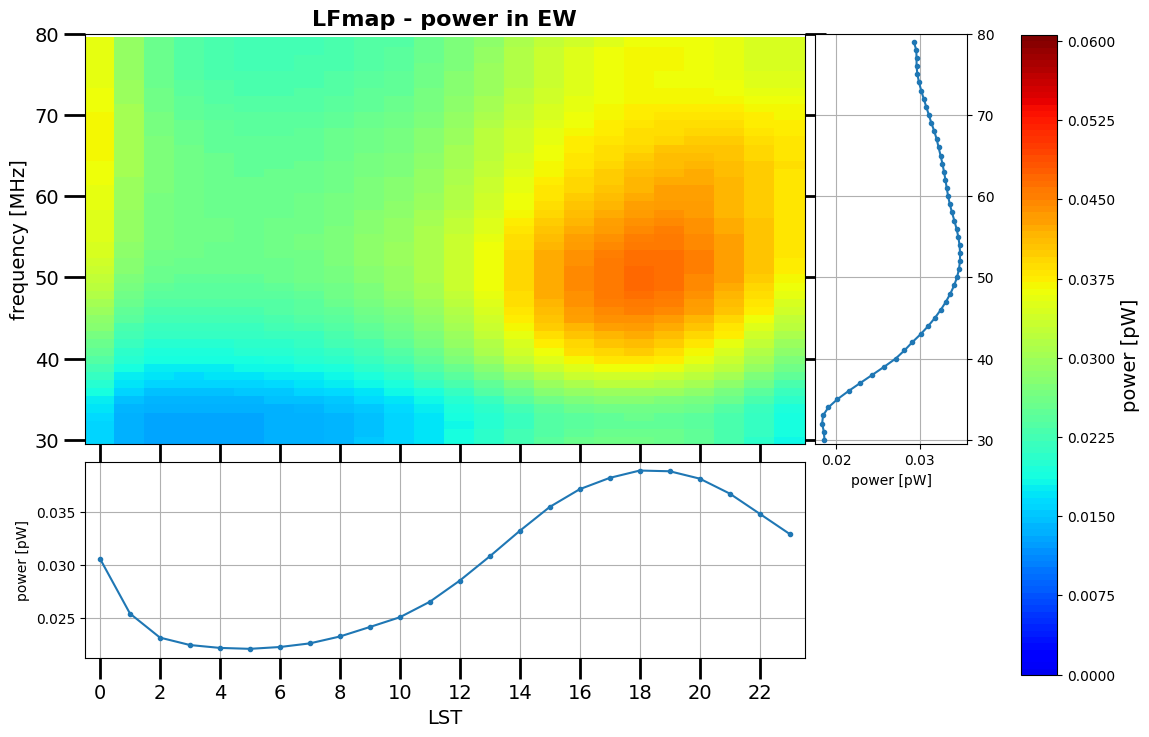

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerDF_GSM2016_EW


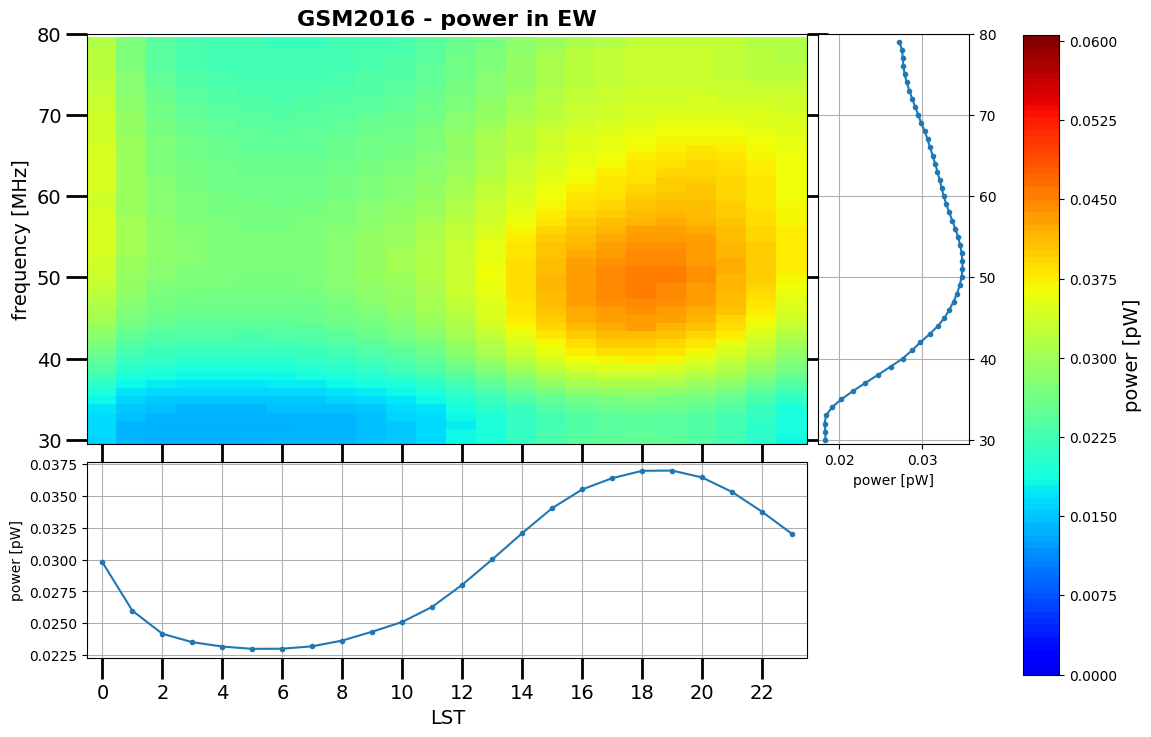

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_Power_LFmap_GSM2016_EW


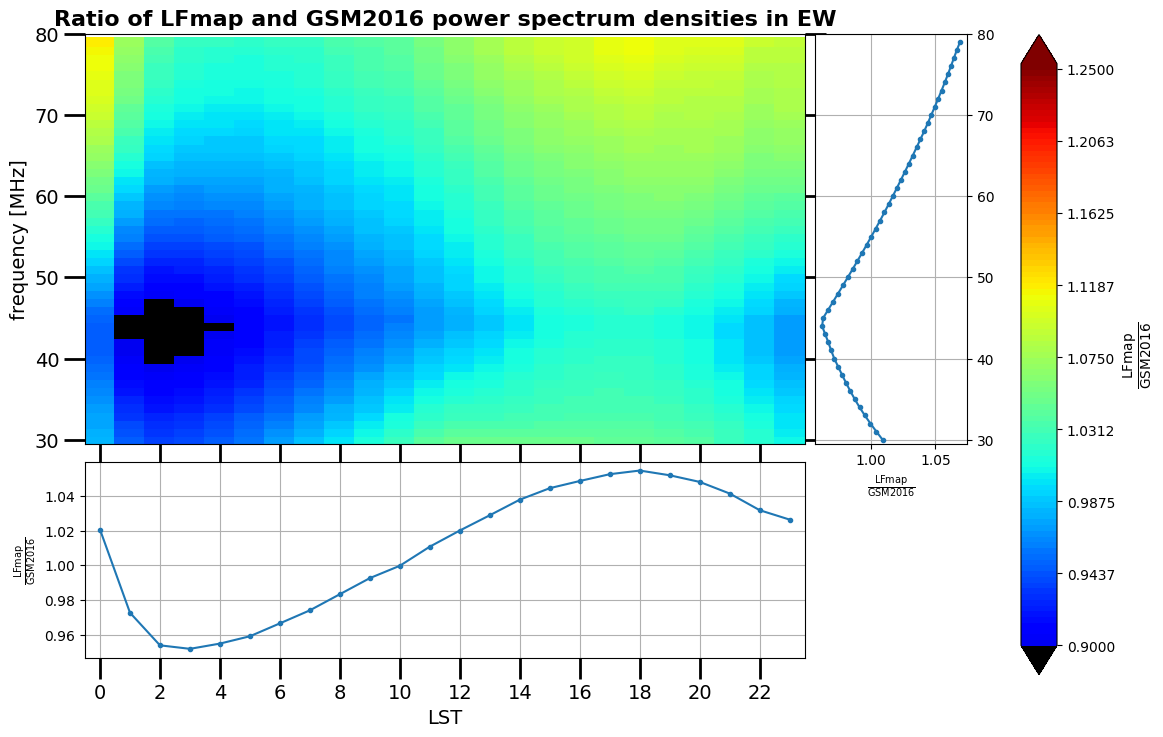

In [139]:
orientation = 'EW'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerDF_'+map_1_title+'_EW'
save2 = saveFolder+'powerDF_'+map_2_title+'_EW'
save3 = saveFolder+'Ratio_Power_'+map_1_title+'_'+map_2_title+'_EW'

LST_grid, freq_grid = np.meshgrid(powerDF_1_EW.index.values.astype(float), powerDF_1_EW.columns.values.astype(float))
myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_1_EW.values.T*1e+12, slices=True,figureWidth=12, figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]', cbarLabel='power [pW]',xMajorLocator=2, yMajorLocator=10,
                    mainTitle=map_1_title+" - power in "+orientation, Cmin=0, Cmax=0.06, ymin=29.5, ymax=80,
                    save=save1, close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_2_EW.values.T*1e+12, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST', ylabel='frequency [MHz]', cbarLabel='power [pW]', xMajorLocator=2, yMajorLocator=10,
                    mainTitle=map_2_title+" - power in "+orientation, Cmin=0, Cmax=0.06, ymin=29.5, ymax=80,
                    save=save2, close=close)

ratio = powerDF_1_EW.values/powerDF_2_EW.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST', ylabel='frequency [MHz]', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title), xMajorLocator=2, yMajorLocator=10,
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25, ymin=29.5, ymax=80,
                    extend='both',
                    save=save3, close=close)

### Plots - Power in NS orientation

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerDF_LFmap_NS


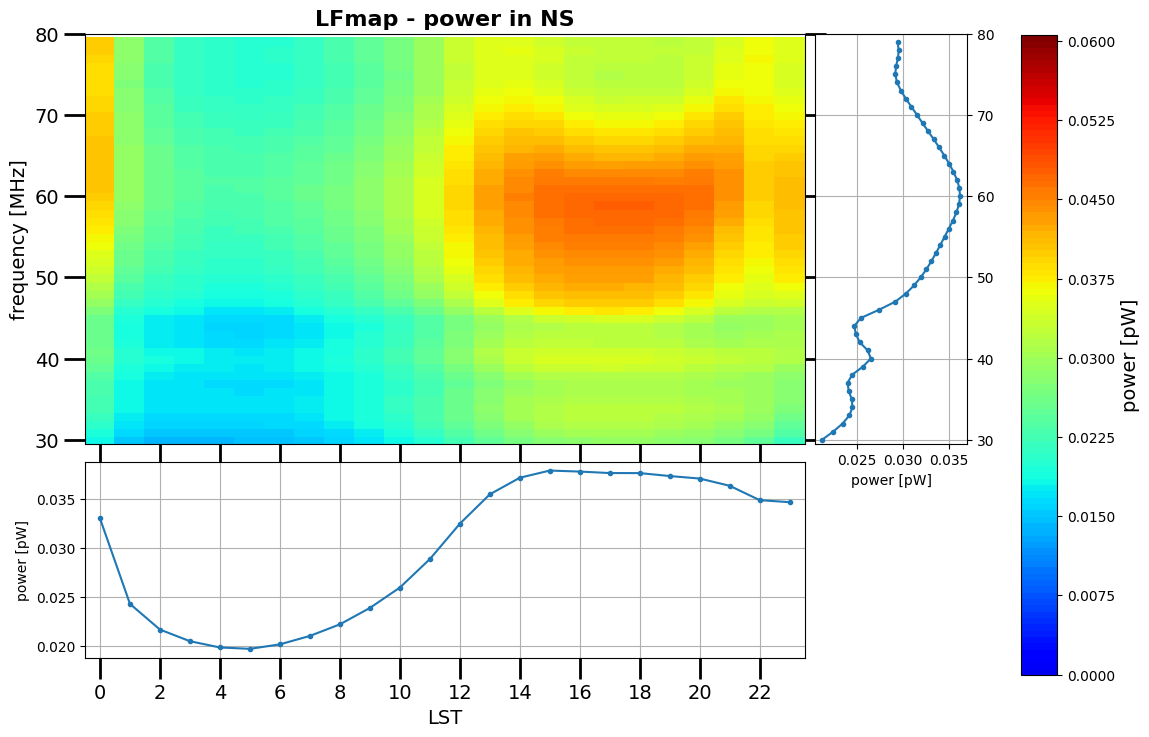

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/powerDF_GSM2016_NS


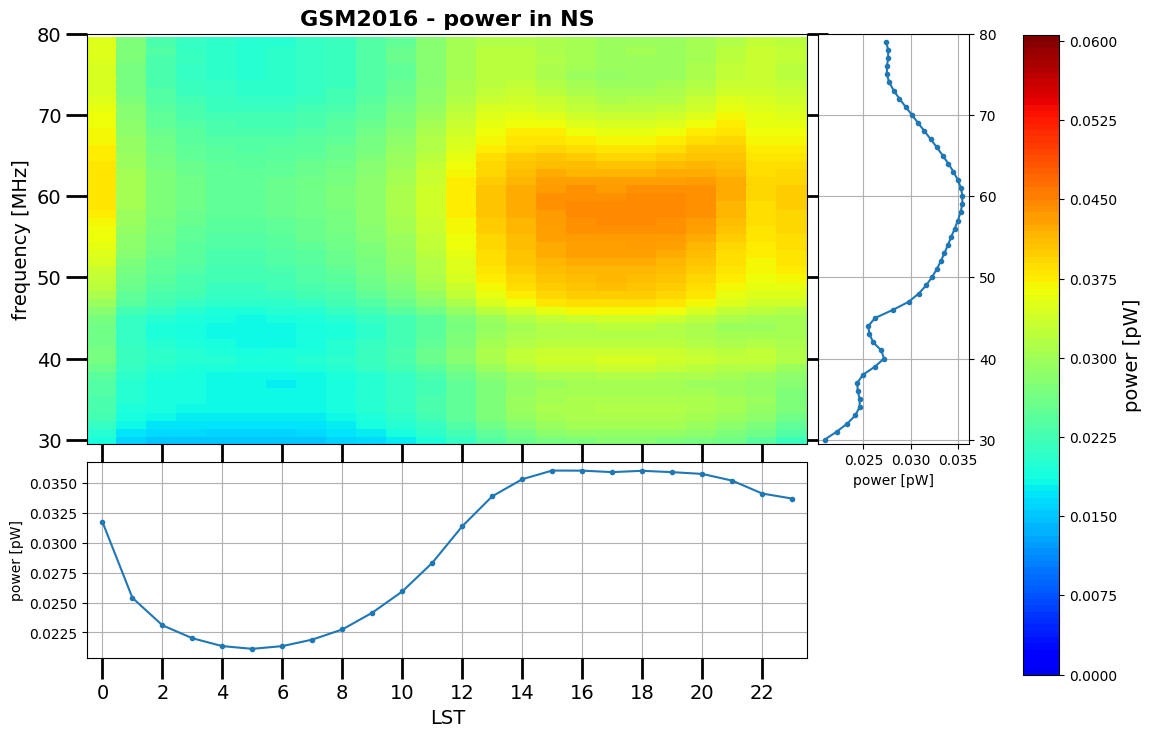

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]
Creation of the directory failed (already exists?)
Figure has been saved to:  ./results/skySimulation/Ratio_Power_LFmap_GSM2016_NS


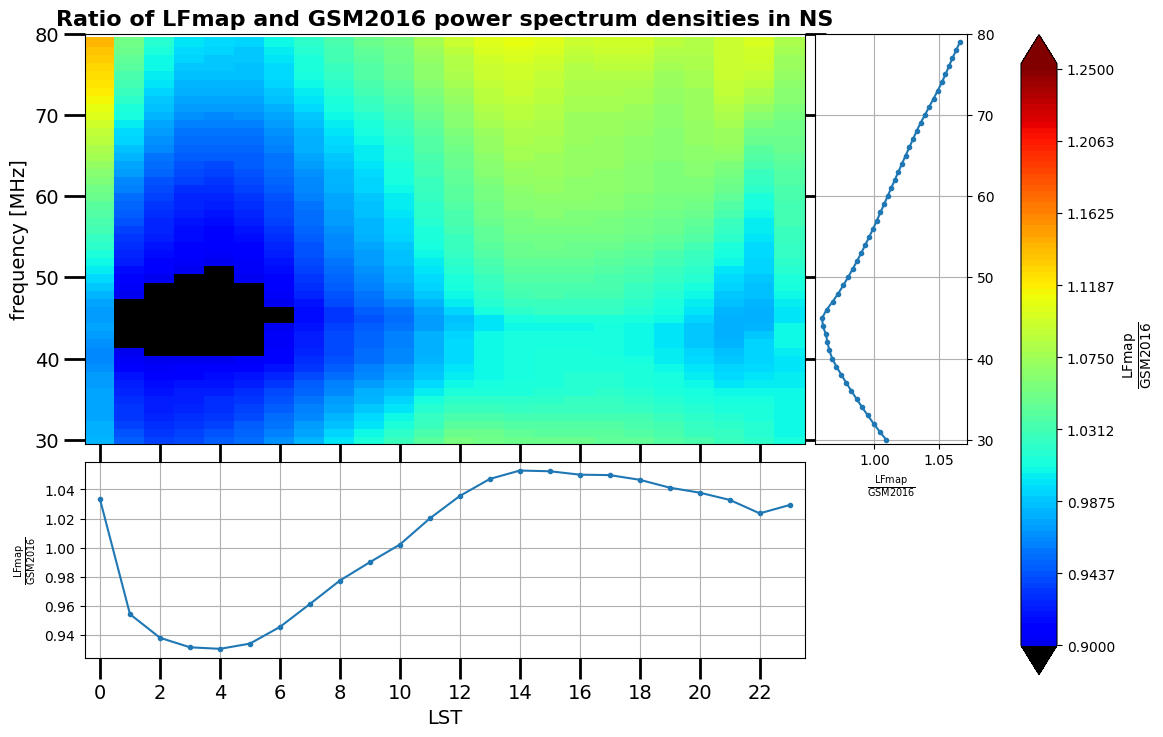

In [142]:
orientation = 'NS'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerDF_'+map_1_title+'_NS'
save2 = saveFolder+'powerDF_'+map_2_title+'_NS'
save3 = saveFolder+'Ratio_Power_'+map_1_title+'_'+map_2_title+'_NS'

LST_grid, freq_grid = np.meshgrid(powerDF_1_NS.index.values.astype(float), powerDF_1_NS.columns.values.astype(float))
myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_1_NS.values.T*1e+12, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST', ylabel='frequency [MHz]', cbarLabel='power [pW]', xMajorLocator=2, yMajorLocator=10,
                    mainTitle=map_1_title+" - power in "+orientation, Cmin=0, Cmax=0.06, ymin=29.5, ymax=80,
                    save=save1, close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_2_NS.values.T*1e+12, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST', ylabel='frequency [MHz]', cbarLabel='power [pW]', xMajorLocator=2, yMajorLocator=10,
                    mainTitle=map_2_title+" - power in "+orientation, Cmin=0, Cmax=0.06, ymin=29.5, ymax=80,
                    save=save2, close=close)

ratio = powerDF_1_NS.values/powerDF_2_NS.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T, slices=True, figureWidth=12, figureHeight=8,
                    xlabel='LST', ylabel='frequency [MHz]', cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title), xMajorLocator=2, yMajorLocator=10,
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25, ymin=29.5, ymax=80,
                    extend='both',
                    save=save3, close=close)